In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy import sparse

# in-cell imports:
# import warnings
# from scipy import stats
# from scipy import spatial
# import pathlib
# from pathlib import Path

%matplotlib inline

# Load & subset data

In [2]:
adata = ad.read_h5ad("/root/capsule/data/merfish_609882and638850_AIT17_annotated_TH_ZI_only_shared_genes_only_2023-04-07_00-00-00/Brain_1_3_TH_ZI.h5ad")
adata

AnnData object with n_obs × n_vars = 606012 × 276
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount', 'corrected_x', 'corrected_y', 'origin', 'rotation', 'section', 'animal', 'merscope', 'target_atlas_plate', 'codebook', 'min_genes', 'min_total_reads', 'min_vol', 'genes_detected', 'total_reads', 'total_blanks', 'spot_density', 'max_blank_count', 'blanks_detected', 'cell_qc', 'best.cl', 'cluster_label', 'cluster_id', 'Level1_id_label', 'Level2_id_label', 'class_id_label', 'clean_region_label', 'prob', 'avg.dist', 'avg.path.cor', 'avg.cor', 'cor.zscore', 'division_id_label', 'subclass_id_label', 'supertype_id_label', 'napari_x', 'napari_y', 'is_in_TH_or_ZI'
    obsm: 'X_tSNE', 'spatial', 'spatial_cirro', 'spatial_rotated'
    layers: 'log2p', 'raw'

## gene lists

In [3]:
# get lists of gene names, excluding blank codewords
genes = [x for x in adata.var_names if 'Blank' not in x]
print(len(genes), 'genes shared between brain1 & brain3\'s gene panels\n', genes)

226 genes shared between brain1 & brain3's gene panels
 ['Trhde', 'Grp', 'Calcr', 'Gad2', 'Pth2r', 'Caln1', 'Rprm', 'Dlk1', 'Calb2', 'Bcl11b', 'Nptx2', 'Cbln4', 'Cd24a', 'Cnr1', 'Sorcs3', 'Ramp1', 'Ctxn3', 'Scn4b', 'Col24a1', 'Nrp1', 'Otp', 'Nr4a2', 'Cacng3', 'Rspo1', 'Lhx1', 'Unc5d', 'Fosl2', 'Pax6', 'Lypd1', 'Lmo1', 'Ebf1', 'Gpc3', 'Cpne8', 'Lpl', 'Prlr', 'Mog', 'Bcl11a', 'Chrm2', 'Nxph1', 'Pou3f1', 'Syt17', 'Cdh9', 'Egr2', 'Crym', 'Syndig1l', 'St6galnac5', 'Hs3st4', 'Egln3', 'Rgs4', 'Th', 'Pcp4l1', 'Otx2', 'Gda', 'Whrn', 'Grem1', 'Zic1', 'Penk', 'Lpar1', 'Galnt14', 'Clic5', 'Moxd1', 'Sox6', 'Bnc2', 'Nxph4', 'Crhbp', 'Cgnl1', 'Vcan', 'Cartpt', 'Nr4a3', 'Galr1', 'Npnt', 'Pou6f2', 'Hcrtr2', 'Bmp3', 'Kcng1', 'Acta2', 'Zfpm2', 'Rasgrp1', 'Sema5a', 'Fign', 'Igf2', 'Cnih3', 'Gpr101', 'Slc1a3', 'Col8a1', 'Kcnj8', 'Cbln2', 'Ptprm', 'Kcnip1', 'Ecel1', 'Ppp1r17', 'Grik1', 'Cbln1', 'Igfbp2', 'Chn2', 'Kitl', 'Grm8', 'Abi3bp', 'Syt6', 'St18', 'Npas1', 'Cyp26b1', 'Reln', 'Lhx8', 'Pitx2', 'Oxtr', '

In [4]:
# blanks have the naming convention "Blank-###"
#   Note that because brain1 & brain3 have different codebooks AND different 
#   number of blanks (brain1=200, brain3=50), blanks with the same "Blank-###" 
#   label should be considered the same *in name only* and not the same in terms
#   of counts, etc.
blanks = [x for x in adata.var_names if 'Blank' in x]
print(len(blanks), '\"shared\" blanks in brain1 & brain3\'s gene panels\n', blanks)

50 "shared" blanks in brain1 & brain3's gene panels
 ['Blank-40', 'Blank-25', 'Blank-41', 'Blank-7', 'Blank-50', 'Blank-17', 'Blank-27', 'Blank-34', 'Blank-16', 'Blank-45', 'Blank-6', 'Blank-3', 'Blank-44', 'Blank-31', 'Blank-15', 'Blank-12', 'Blank-8', 'Blank-11', 'Blank-29', 'Blank-13', 'Blank-10', 'Blank-33', 'Blank-43', 'Blank-4', 'Blank-18', 'Blank-22', 'Blank-9', 'Blank-14', 'Blank-24', 'Blank-21', 'Blank-36', 'Blank-19', 'Blank-26', 'Blank-47', 'Blank-48', 'Blank-2', 'Blank-49', 'Blank-30', 'Blank-1', 'Blank-5', 'Blank-37', 'Blank-23', 'Blank-38', 'Blank-46', 'Blank-28', 'Blank-20', 'Blank-42', 'Blank-39', 'Blank-35', 'Blank-32']


## subset by brain

In [5]:
# view obs columns that might allow for easy filtering of brain1 vs brain3
#  - animal *should* be different, but isn't, likely due to weird anndata 
#      behavior when concatenating brain1 & brain3 objects
#  - using codebook going forward since it's the one I'm next-most-confident 
#      should be consistent within each brain
# - NB: updated version of this h5ad in Brian's isilon folder has a column
adata.obs[['section', 'animal', 'merscope', 'target_atlas_plate', 'codebook']]

section  \
914110044101570959     1198980071   
914110044101570965     1198980071   
914110044101570967     1198980071   
914110044101570972     1198980071   
914110044101570984     1198980071   
...                           ...   
1018093345101450568    1199651063   
1018093345101450782-1  1199651063   
1018093345102290302    1199651063   
1018093345102280266-1  1199651063   
1018093345101590813    1199651063   

                                                                  animal  \
914110044101570959     914110044101570959       914110044101570959   ...   
914110044101570965     914110044101570959       914110044101570959   ...   
914110044101570967     914110044101570959       914110044101570959   ...   
914110044101570972     914110044101570959       914110044101570959   ...   
914110044101570984     914110044101570959       914110044101570959   ...   
...                                                                  ...   
1018093345101450568    914110044101570959       914110044101570959   ...   
1018093345101450782-1  914110044101570959       914110044101570959   ...   
1018093345102290302    914110044101570959       914110044101570959   ...   
1018093345102280266-1  914110044101570959       914110044101570959   ...   
1018093345101590813    914110044101570959       914110044101570959   ...   

                       merscope  target_atlas_plate           codebook  
914110044101570959     Triton04                63.0             VZG147  
914110044101570965     Triton04                63.0             VZG147  
914110044101570967     Triton04                63.0             VZG147  
914110044101570972     Triton04                63.0             VZG147  
914110044101570984     Triton04                63.0             VZG147  
...                         ...                 ...                ...  
1018093345101450568       Coral                49.0  wholebrain031822a  
1018093345101450782-1     Coral                49.0  wholebrain031822a  
1018093345102290302       Coral                49.0  wholebrain031822a  
1018093345102280266-1     Coral                49.0  wholebrain031822a  
1018093345101590813       Coral                49.0  wholebrain031822a  

[606012 rows x 5 columns]

In [6]:
# Distinguish between the two brains by using the codebook names
codebook_brain1 = 'VZG147'
codebook_brain3 = 'wholebrain031822a'

# Split up the two brains
adata_brain1 = adata[adata.obs['codebook']==codebook_brain1].copy()
# ad_brain1_blanks = adata[adata.obs['codebook']==codebook_brain1, blanks]

adata_brain3 = adata[adata.obs['codebook']==codebook_brain3].copy()

In [7]:
adata_brain1

AnnData object with n_obs × n_vars = 414434 × 276
    obs: 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'barcodeCount', 'corrected_x', 'corrected_y', 'origin', 'rotation', 'section', 'animal', 'merscope', 'target_atlas_plate', 'codebook', 'min_genes', 'min_total_reads', 'min_vol', 'genes_detected', 'total_reads', 'total_blanks', 'spot_density', 'max_blank_count', 'blanks_detected', 'cell_qc', 'best.cl', 'cluster_label', 'cluster_id', 'Level1_id_label', 'Level2_id_label', 'class_id_label', 'clean_region_label', 'prob', 'avg.dist', 'avg.path.cor', 'avg.cor', 'cor.zscore', 'division_id_label', 'subclass_id_label', 'supertype_id_label', 'napari_x', 'napari_y', 'is_in_TH_or_ZI'
    obsm: 'X_tSNE', 'spatial', 'spatial_cirro', 'spatial_rotated'
    layers: 'log2p', 'raw'

### define division & subclass filters

In [8]:
# Division labels for just the neurons in the thalamus
#   NB: division_id_label is consistent between the two taxonomy mappings,
#       AIT17.0 and AIT17.custom, used for brain1 and brain3, whereas 
#       class_id_label may *look* similar to division labels but are NOT 
#       necessarily consistent across brains
divisions_neuron = [
                    '1 Pallium glutamatergic',
                    '2 Subpallium GABAergic',
                    '3 PAL-sAMY-TH-HY-MB-HB neuronal',
                    '4 CBX-MOB-other neuronal'
                   ]

# Create brain-specific filters for just the neuronal cells, using the division labels
neuron_filter_brain1 = adata_brain1.obs['division_id_label'].isin(divisions_neuron)
neuron_filter_brain3 = adata_brain3.obs['division_id_label'].isin(divisions_neuron)

In [9]:
# Use subclass_id_label to distinguish between excitatory (exc) and 
# inhibitory (inh) cells
#   NB: subclass_id_label is NOT fully consistent between the two taxonomy
#       mappings, AIT17.0 and AIT17.custom, used for brain1 and brain3, 
#       respectively, so be cautious using anything more specific than 'glut'
#       vs 'gaba' filtering
exc_cell_str = 'glut'
inh_cell_str = 'gaba'

# Filter for excitatory (exc) neurons vs inhibitory (inh) cells
exc_filter_brain1 = adata_brain1.obs['subclass_id_label'].str.contains(exc_cell_str,case=False)
inh_filter_brain1 = adata_brain1.obs['subclass_id_label'].str.contains(inh_cell_str,case=False)

exc_filter_brain3 = adata_brain3.obs['subclass_id_label'].str.contains(exc_cell_str,case=False)
inh_filter_brain3 = adata_brain3.obs['subclass_id_label'].str.contains(inh_cell_str,case=False)

In [10]:
# combined
exc_neuron_filter_brain1 = exc_filter_brain1 & neuron_filter_brain1
inh_neuron_filter_brain1 = inh_filter_brain1 & neuron_filter_brain1

exc_neuron_filter_brain3 = exc_filter_brain3 & neuron_filter_brain3
inh_neuron_filter_brain3 = inh_filter_brain3 & neuron_filter_brain3

# Compare mean gene reads in brain1 vs brain3

In [11]:
# Create a df of all the genes so that we can easily compare all the flags 
# we're about to generate
gene_flags_df = pd.DataFrame(index=genes)

## plot_brain1_vs_brain3_reads()

In [12]:
# Function to generate a scatter plot of gene-by-gene comparisons between
# brain1 & brain3
def plot_brain1_vs_brain3_reads(gene_reads_brain1, gene_reads_brain3,
                                blank_reads_brain1, blank_reads_brain3,
                                genes, subset, **kwargs):
    
    # TODO: add type-enforcement?
    genes_to_highlight = kwargs.get('genes_to_highlight', None) # string or list of strings
    
    fig, ax = plt.subplots(figsize=(11,9))

    # Scatter plot of brain1 vs brain3 reads
    ax.scatter(gene_reads_brain1, gene_reads_brain3, 
               s=18, color='cornflowerblue')
    # label each data point with the gene name, using a non-black color to 
    # highlight user-specified genes, if they exist
    if genes_to_highlight is None:
        for i, gene in enumerate(genes):
            ax.annotate(genes[i], 
                        (gene_reads_brain1[i], gene_reads_brain3[i]), 
                        fontsize=10, color='k')
    else:
        for i, gene in enumerate(genes):
            if gene in genes_to_highlight:
                ax.annotate(genes[i], 
                            (gene_reads_brain1[i], gene_reads_brain3[i]), 
                            fontsize=16, color='magenta') 
            else:
                ax.annotate(genes[i], 
                            (gene_reads_brain1[i], gene_reads_brain3[i]), 
                            fontsize=10)

    # Plot the mean blank reads thresholds as a vertical line (brain1) and a
    # horizontal line (brain3)
    vline_ymin = min(gene_reads_brain3) # vert line limits
    vline_ymax = max(gene_reads_brain3) # vert line limits
    hline_xmin = min(gene_reads_brain1) # hor line limits
    hline_xmax = max(gene_reads_brain1) # hor line limits
    ax.vlines(blank_reads_brain1, ymin=vline_ymin, ymax=vline_ymax, 
              color='darkorange', ls='--')
    ax.hlines(blank_reads_brain3, xmin=hline_xmin,xmax=hline_xmax, 
              color='darkorange', ls='--')
    ax.annotate('brain1\nmean blank reads\nper '+subset, 
                (blank_reads_brain1+0.005,10), color='darkorange', fontsize=12)
    ax.annotate('brain3\nmean blank reads\nper '+subset, 
                (3, blank_reads_brain3+0.01), color='darkorange', fontsize=12)

    # Plot a slope=1 line for visual reference of perfect brain1 vs brain3 match
    ax.axline((1,1),slope=1, ls='-',c='darkgrey')

    # Axis formatting
    # ax.set_aspect('equal')
    ax.set_xlabel('brain1\n'+'mean gene reads per '+subset)
    ax.set_ylabel('brain3\n'+'mean gene reads per '+subset)
    ax.tick_params('both', which='both', direction='in', top=True, right=True,
                   color='grey')
    ax.spines['bottom'].set_color('grey')
    ax.spines['top'].set_color('grey') 
    ax.spines['right'].set_color('grey')
    ax.spines['left'].set_color('grey')
    ax.set_xscale('log')
    ax.set_yscale('log')
    # special function needed to get the major tick labels to display correctly
    # on log axes in non-scientific number format
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

    plt.show()

## In all thalamic cells

In [13]:
# For all cells
subset = 'cell'

# Calculate mean reads per cell, for each gene
mean_gene_reads_per_cell_brain1 = adata_brain1[:, genes].X.A.mean(axis=0)
mean_gene_reads_per_cell_brain3 = adata_brain3[:, genes].X.A.mean(axis=0)

# Calculate overall mean of the mean blank reads per cell
mean_blank_reads_per_cell_brain1 = np.mean(adata_brain1[:, blanks].X.A.mean(axis=1))
mean_blank_reads_per_cell_brain3 = np.mean(adata_brain3[:, blanks].X.A.mean(axis=1))

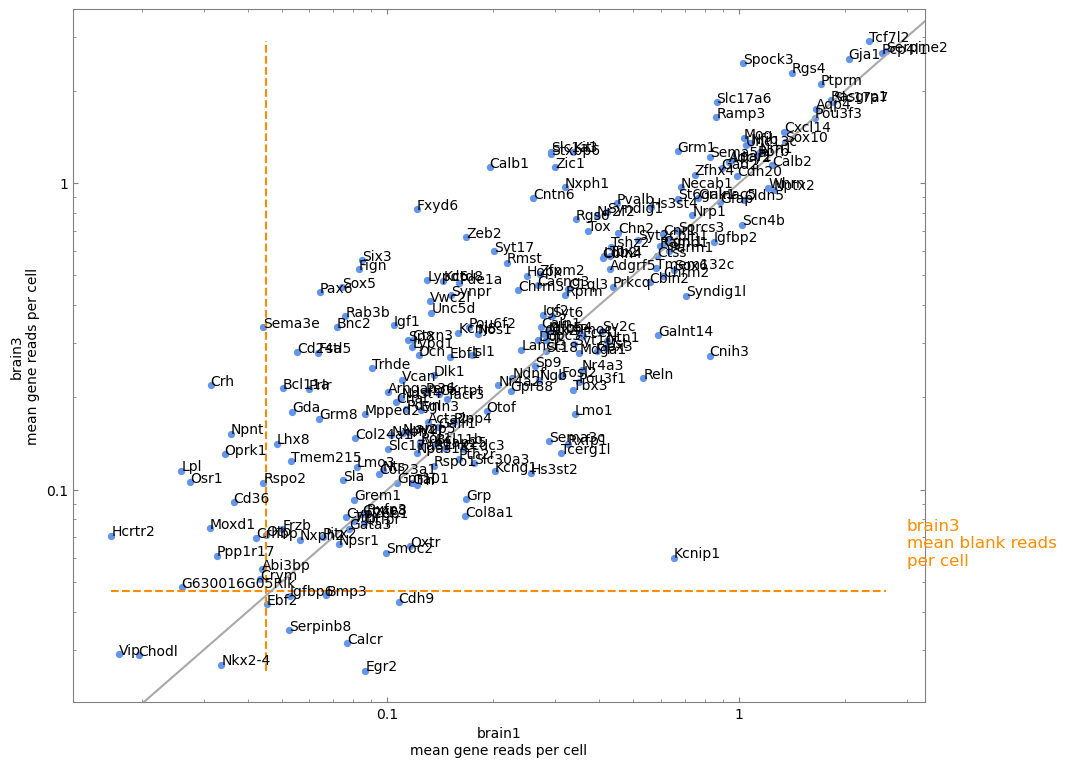

In [14]:
# Plot
plot_brain1_vs_brain3_reads(mean_gene_reads_per_cell_brain1, 
                            mean_gene_reads_per_cell_brain3,
                            mean_blank_reads_per_cell_brain1,
                            mean_blank_reads_per_cell_brain3,
                            genes, subset, genes_to_highlight=None) #genes_to_highlight=['Npsr1', 'Gad2'])

# Flag & store genes that have mean reads in neurons below the overall mean blank read
gene_flags_df['below_blanks_all_cells_brain1'] = mean_gene_reads_per_cell_brain1 <= mean_blank_reads_per_cell_brain1
gene_flags_df['below_blanks_all_cells_brain3'] = mean_gene_reads_per_cell_brain3 <= mean_blank_reads_per_cell_brain3

## In neurons

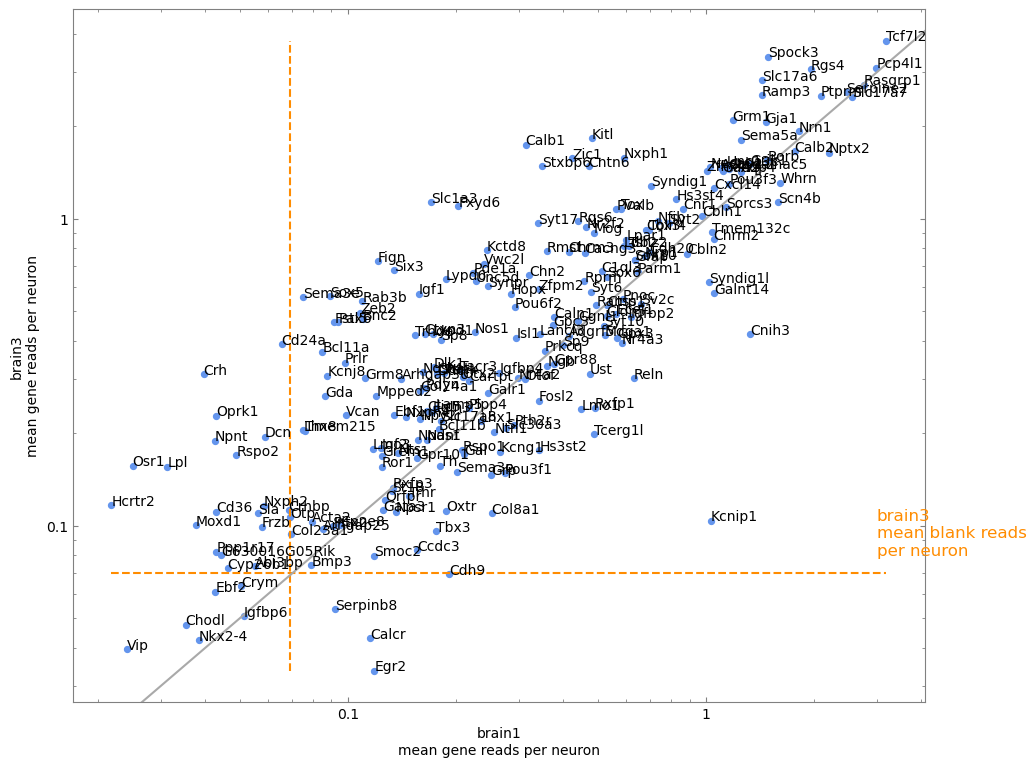

In [15]:
# For only neurons
subset = 'neuron'

# Calculate mean reads per cell, for each gene
mean_gene_reads_per_neuron_brain1 = adata_brain1[neuron_filter_brain1, genes].X.A.mean(axis=0)
mean_gene_reads_per_neuron_brain3 = adata_brain3[neuron_filter_brain3, genes].X.A.mean(axis=0)

# Calculate overall mean of the mean blank reads per cell
mean_blank_reads_per_neuron_brain1 = np.mean(adata_brain1[neuron_filter_brain1, blanks].X.A.mean(axis=1))
mean_blank_reads_per_neuron_brain3 = np.mean(adata_brain3[neuron_filter_brain3, blanks].X.A.mean(axis=1))

# Plot - uncomment below to view
plot_brain1_vs_brain3_reads(mean_gene_reads_per_neuron_brain1, 
                            mean_gene_reads_per_neuron_brain3,
                            mean_blank_reads_per_neuron_brain1,
                            mean_blank_reads_per_neuron_brain3,
                            genes, subset)

# Flag & store genes that have mean reads in neurons below the overall mean blank read
gene_flags_df['below_blanks_in_neurons_brain1'] = mean_gene_reads_per_neuron_brain1 <= mean_blank_reads_per_neuron_brain1
gene_flags_df['below_blanks_in_neurons_brain3'] = mean_gene_reads_per_neuron_brain3 <= mean_blank_reads_per_neuron_brain3

## In non-neurons

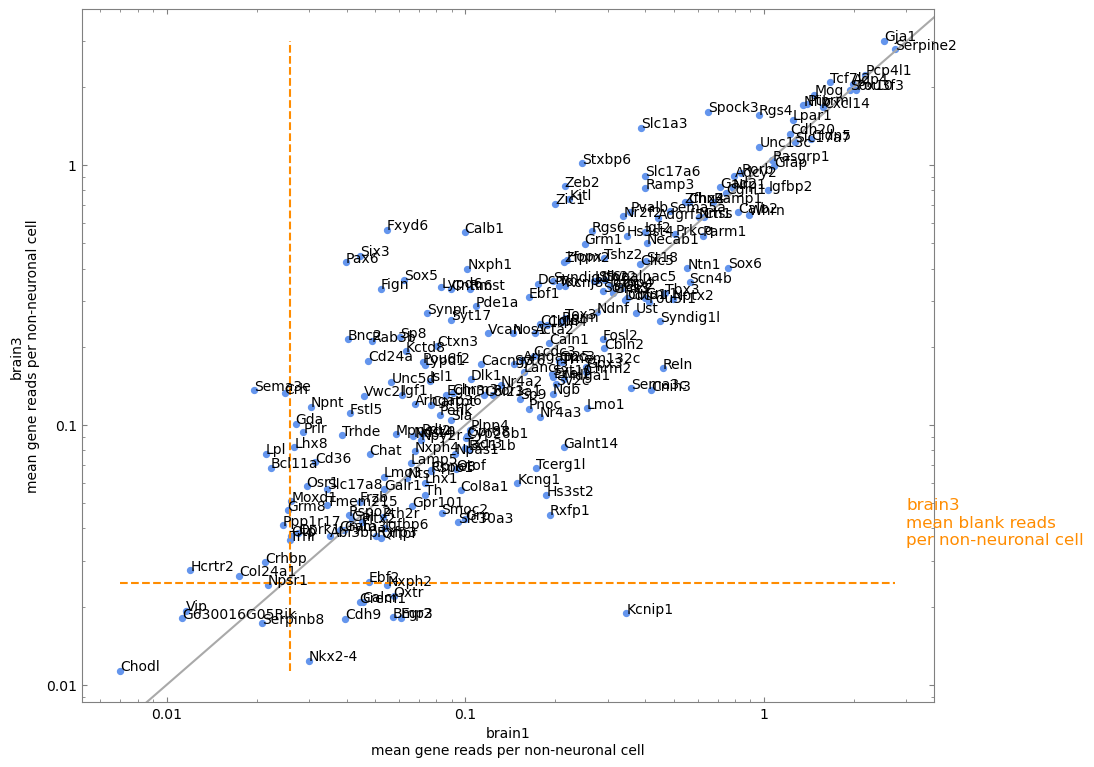

In [16]:
# For only non-neuronal cells
subset = 'non-neuronal cell'

# Calculate mean reads per cell, for each gene
mean_gene_reads_per_nn_brain1 = adata_brain1[~neuron_filter_brain1, genes].X.A.mean(axis=0)
mean_gene_reads_per_nn_brain3 = adata_brain3[~neuron_filter_brain3, genes].X.A.mean(axis=0)

# Calculate overall mean of the mean blank reads per cell
mean_blank_reads_per_nn_brain1 = np.mean(adata_brain1[~neuron_filter_brain1, blanks].X.A.mean(axis=1))
mean_blank_reads_per_nn_brain3 = np.mean(adata_brain3[~neuron_filter_brain3, blanks].X.A.mean(axis=1))

# Plot - uncomment below to view
plot_brain1_vs_brain3_reads(mean_gene_reads_per_nn_brain1, 
                            mean_gene_reads_per_nn_brain3,
                            mean_blank_reads_per_nn_brain1,
                            mean_blank_reads_per_nn_brain3,
                            genes, subset)

# Flag & store genes that have mean reads in non-neuronal cells below the overall mean blank read
gene_flags_df['below_blanks_in_nn_brain1'] = mean_gene_reads_per_nn_brain1 <= mean_blank_reads_per_nn_brain1
gene_flags_df['below_blanks_in_nn_brain3'] = mean_gene_reads_per_nn_brain3 <= mean_blank_reads_per_nn_brain3

## In excitatory neurons

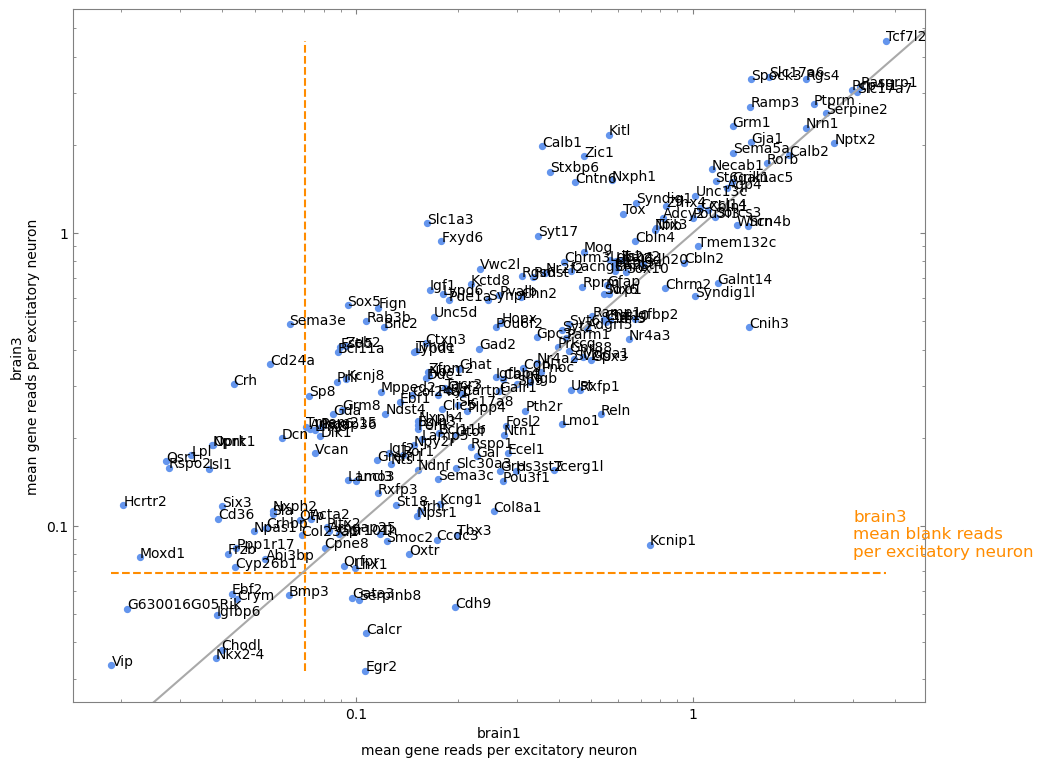

In [17]:
# For only excitatory neurons
subset = 'excitatory neuron'

# Calculate mean reads per cell, for each gene
mean_gene_reads_per_exc_brain1 = adata_brain1[exc_neuron_filter_brain1, genes].X.A.mean(axis=0)
mean_gene_reads_per_exc_brain3 = adata_brain3[exc_neuron_filter_brain3, genes].X.A.mean(axis=0)

# Calculate overall mean of the mean blank reads per cell
mean_blank_reads_per_exc_brain1 = np.mean(adata_brain1[exc_neuron_filter_brain1, blanks].X.A.mean(axis=1))
mean_blank_reads_per_exc_brain3 = np.mean(adata_brain3[exc_neuron_filter_brain3, blanks].X.A.mean(axis=1))

# Plot - uncomment below to view
plot_brain1_vs_brain3_reads(mean_gene_reads_per_exc_brain1, 
                            mean_gene_reads_per_exc_brain3,
                            mean_blank_reads_per_exc_brain1,
                            mean_blank_reads_per_exc_brain3,
                            genes, subset)

# Flag & store genes that have mean reads in exc cells below the overall mean blank read
gene_flags_df['below_blanks_in_exc_brain1'] = mean_gene_reads_per_exc_brain1 <= mean_blank_reads_per_exc_brain1
gene_flags_df['below_blanks_in_exc_brain3'] = mean_gene_reads_per_exc_brain3 <= mean_blank_reads_per_exc_brain3

## In inhibitory neurons

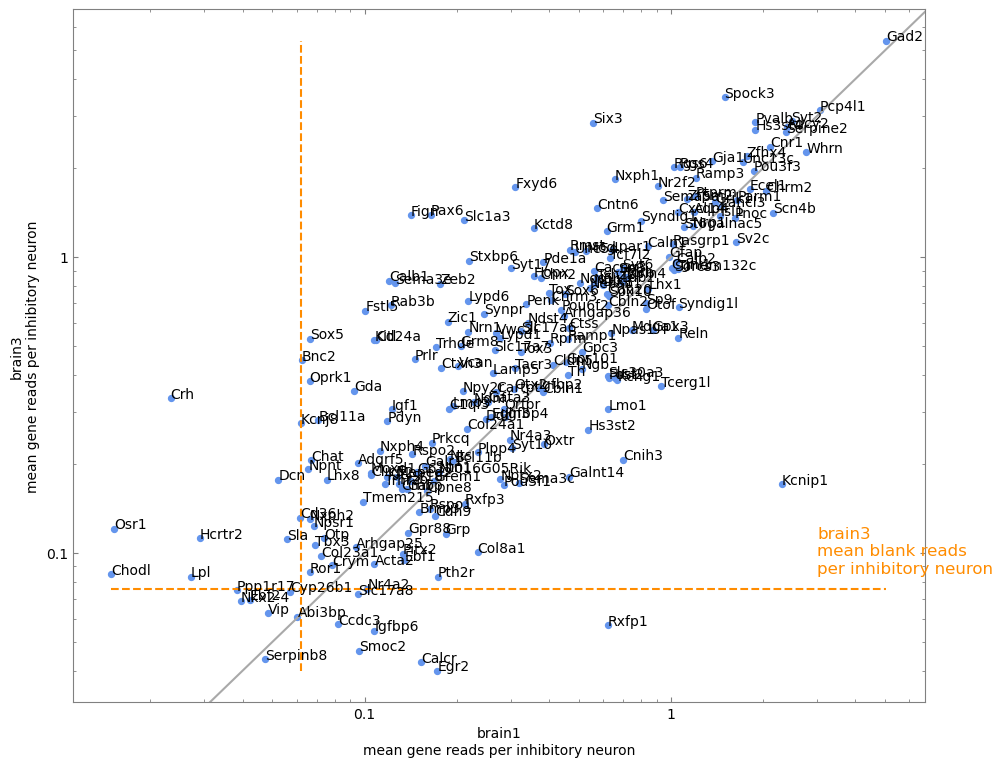

In [18]:
# For only inhibitory neurons
subset = 'inhibitory neuron'

# Calculate mean reads per cell, for each gene
mean_gene_reads_per_inh_brain1 = adata_brain1[inh_neuron_filter_brain1, genes].X.A.mean(axis=0)
mean_gene_reads_per_inh_brain3 = adata_brain3[inh_neuron_filter_brain3, genes].X.A.mean(axis=0)

# Calculate overall mean of the mean blank reads per cell
mean_blank_reads_per_inh_brain1 = np.mean(adata_brain1[inh_neuron_filter_brain1, blanks].X.A.mean(axis=1))
mean_blank_reads_per_inh_brain3 = np.mean(adata_brain3[inh_neuron_filter_brain3, blanks].X.A.mean(axis=1))

# Plot - uncomment below to view
plot_brain1_vs_brain3_reads(mean_gene_reads_per_inh_brain1, 
                            mean_gene_reads_per_inh_brain3,
                            mean_blank_reads_per_inh_brain1,
                            mean_blank_reads_per_inh_brain3,
                            genes, subset)

# Flag & store genes that have mean reads in inh cells below the overall mean blank read
gene_flags_df['below_blanks_in_inh_brain1'] = mean_gene_reads_per_inh_brain1 <= mean_blank_reads_per_inh_brain1
gene_flags_df['below_blanks_in_inh_brain3'] = mean_gene_reads_per_inh_brain3 <= mean_blank_reads_per_inh_brain3

## Which genes were flagged for below-blank reads?

In [19]:
blank_flagged_all_genes = gene_flags_df.index[gene_flags_df.sum(axis=1)>0]

# Note: all blank-flagged genes were flagged in both brains by one of the thresholds, but I'm keeping these just in case I want to confirm/show that
blank_flagged_brain1_genes = gene_flags_df[gene_flags_df.filter(regex='brain1').columns].index[gene_flags_df.sum(axis=1)>0]
blank_flagged_brain3_genes = gene_flags_df[gene_flags_df.filter(regex='brain3').columns].index[gene_flags_df.sum(axis=1)>0]

blank_flagged_brain1 = sorted(gene_flags_df[gene_flags_df['below_blanks_all_cells_brain1']==1].index)
blank_flagged_brain3 = sorted(gene_flags_df[gene_flags_df['below_blanks_all_cells_brain3']==1].index)
blank_flagged_both = sorted(list(set(blank_flagged_brain1).intersection(set(blank_flagged_brain3))))
blank_flagged_brain1only = sorted(list(set(blank_flagged_brain1) - (set(blank_flagged_brain3))))
blank_flagged_brain3only = sorted(list(set(blank_flagged_brain3) - (set(blank_flagged_brain1))))

print('Genes with low avg expression in either brain, any subset of cells:', blank_flagged_all_genes.to_list())
print('\nGenes with low avg expression in Brain 1 only: ', blank_flagged_brain1only)
print('Genes with low avg expression in Brain 3 only: ', blank_flagged_brain3only)
print('Genes with low avg expression in both brains: ', blank_flagged_both)

Genes with low avg expression in either brain, any subset of cells: ['Calcr', 'Cd24a', 'Col24a1', 'Otp', 'Lpl', 'Bcl11a', 'Cdh9', 'Egr2', 'Crym', 'Grem1', 'Moxd1', 'Crhbp', 'Npnt', 'Hcrtr2', 'Bmp3', 'Kcnj8', 'Kcnip1', 'Ppp1r17', 'Grm8', 'Abi3bp', 'Npas1', 'Cyp26b1', 'Oxtr', 'Slc17a8', 'Sla', 'Nkx2-4', 'Osr1', 'Gata3', 'G630016G05Rik', 'Sema3e', 'Col23a1', 'Serpinb8', 'Ebf2', 'Chodl', 'Npsr1', 'Vip', 'Igfbp6', 'Isl1', 'Dcn', 'Crh', 'Cd36', 'Smoc2', 'Nxph2', 'Oprk1', 'Six3', 'Ccdc3', 'Rspo2', 'Frzb', 'Rxfp1']

Genes with low avg expression in Brain 1 only:  ['Abi3bp', 'Cd36', 'Crh', 'Crhbp', 'Crym', 'G630016G05Rik', 'Hcrtr2', 'Lpl', 'Moxd1', 'Npnt', 'Oprk1', 'Osr1', 'Ppp1r17', 'Rspo2', 'Sema3e']
Genes with low avg expression in Brain 3 only:  ['Bmp3', 'Calcr', 'Cdh9', 'Ebf2', 'Egr2', 'Igfbp6', 'Serpinb8']
Genes with low avg expression in both brains:  ['Chodl', 'Nkx2-4', 'Vip']


## Save qc flags to .uns & save adata to results

In [20]:
adata.uns['gene_qc_flags'] = gene_flags_df
adata.write_h5ad('/root/capsule/results/Brain_1_3_TH_ZI_geneQC.h5ad')

# Variance, CV vs mean for brain1 & brain3

In [32]:
# calculate
b1_mean = adata_brain1[:, genes].X.A.mean(axis=0)
b1_var = adata_brain1[:, genes].X.A.var(axis=0)
b1_std = adata_brain1[:, genes].X.A.std(axis=0)
b1_cv = b1_std / b1_mean

b3_mean = adata_brain3[:, genes].X.A.mean(axis=0)
b3_var = adata_brain3[:, genes].X.A.var(axis=0)
b3_std = adata_brain3[:, genes].X.A.std(axis=0)
b3_cv = b3_std / b3_mean

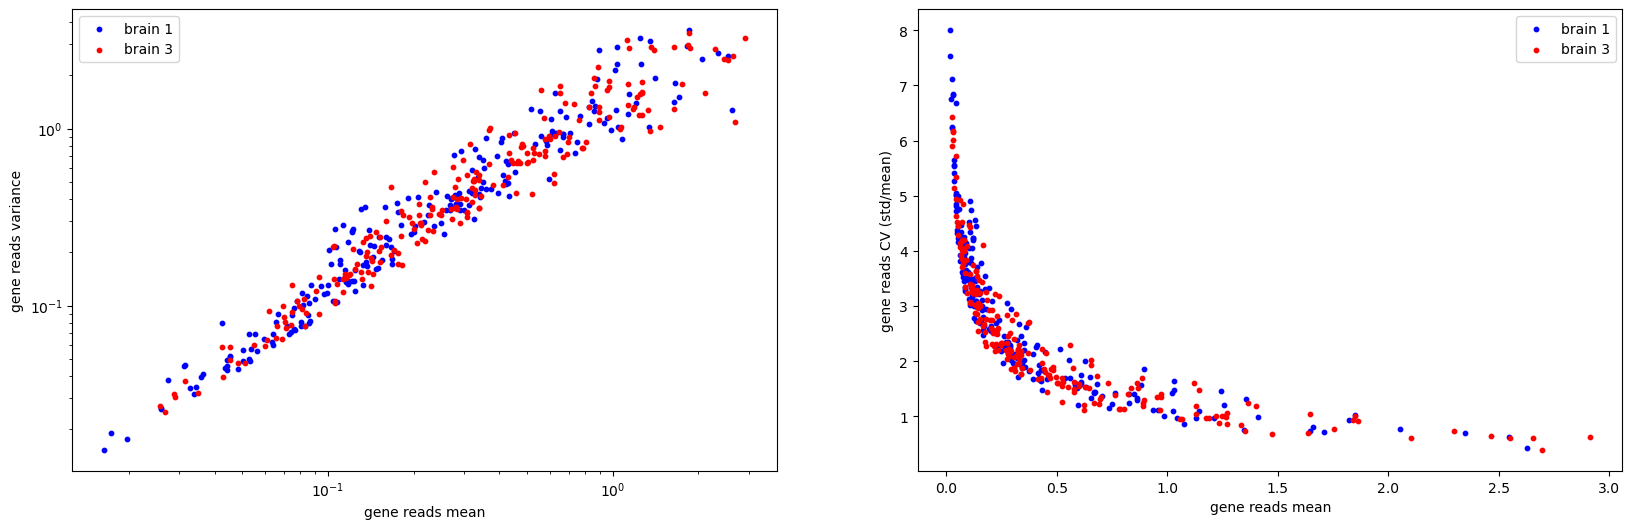

In [36]:
# plot mean vs var
fig, axes = plt.subplots(1,2, figsize=(20,6))
ax = axes[0]
ax.scatter(b1_mean, b1_var, s=10, color='b', label='brain 1') #c=np.arange(len(brain_1_genes_df.mean())), cmap='Spectral', marker='o')
ax.scatter(b3_mean, b3_var, s=10, color='r', label='brain 3') # c=np.arange(len(brain_3_genes_df.mean())), cmap='Spectral', marker='^')
# for i, gene in enumerate(genes):
#     ax.annotate(genes[i], (b1_mean[i], b1_var[i]))
ax.set_xlabel('gene reads mean')
ax.set_ylabel('gene reads variance')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

# plot mean vs CV
ax = axes[1]
ax.scatter(b1_mean, b1_cv, s=10, color='b', label='brain 1')
ax.scatter(b3_mean, b3_cv, s=10, color='r', label='brain 3')
# for i, gene in enumerate(genes):
#     ax.annotate(genes[i], (b1_mean[i], b1_cv[i]))
ax.set_xlabel('gene reads mean')
ax.set_ylabel('gene reads CV (std/mean)')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend();

# Compare 95th, 99th, 99.9th percentile of gene reads in brain1 vs brain3

## plot_brain1_vs_brain3_percentile()

In [38]:
# Function to generate a scatter plot of gene-by-gene comparisons between
# brain1 & brain3
def plot_brain1_vs_brain3_percentile(gene_reads_pct_brain1, 
                                     gene_reads_pct_brain3,
                                     genes, percentile, **kwargs):
    
    # TODO: add type-enforcement?
    genes_to_highlight = kwargs.get('genes_to_highlight', None) # string or list of strings
    
    fig, ax = plt.subplots(figsize=(11,9))

    # Scatter plot of brain1 vs brain3 reads
    ax.scatter(gene_reads_pct_brain1, gene_reads_pct_brain3, 
               s=18, color='cornflowerblue')
    
    # label each data point with the gene name, using a non-black color to 
    # highlight user-specified genes, if they exist
    if genes_to_highlight is None:
        for i, gene in enumerate(genes):
            ax.annotate(genes[i], 
                        (gene_reads_pct_brain1[i], gene_reads_pct_brain3[i]), 
                        fontsize=10, color='k')
    else:
        for i, gene in enumerate(genes):
            if gene in genes_to_highlight:
                ax.annotate(genes[i], 
                            (gene_reads_pct_brain1[i], gene_reads_pct_brain3[i]), 
                            fontsize=16, color='magenta') 
            else:
                ax.annotate(genes[i], 
                            (gene_reads_pct_brain1[i], gene_reads_pct_brain3[i]), 
                            fontsize=10)

    # Plot a slope=1 line for visual reference of perfect brain1 vs brain3 match
    ax.axline((1,1),slope=1, ls='-',c='darkgrey')

    # Axis formatting
    # ax.set_aspect('equal')
    ax.set_xlabel('brain1\n'+str(percentile)+'th percentile of gene reads')
    ax.set_ylabel('brain3\n'+str(percentile)+'th percentile of gene reads')
    ax.tick_params('both', which='both', direction='in', top=True, right=True,
                   color='grey')
    ax.spines['bottom'].set_color('grey')
    ax.spines['top'].set_color('grey') 
    ax.spines['right'].set_color('grey')
    ax.spines['left'].set_color('grey')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # # special function needed to get the major tick labels to display correctly
    # # on log axes in non-scientific number format
    # ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
    # ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:g}'.format(x)))

    plt.show()

## 95th percentile

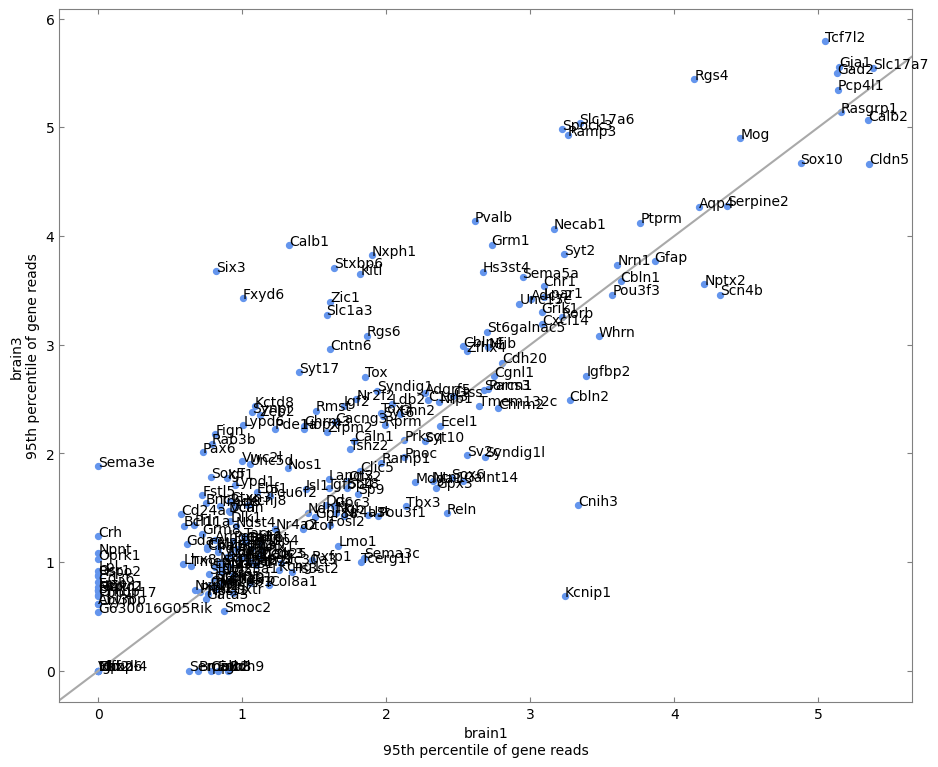

In [39]:
# Plot the 95th percentile of reads for brain1 vs brain3
# Are any gene egregiously off the diagonal?
pct = 0.95
gene_95pct_brain1 = adata_brain1[:,genes].to_df().quantile(pct)
gene_95pct_brain3 = adata_brain3[:,genes].to_df().quantile(pct)

plot_brain1_vs_brain3_percentile(gene_95pct_brain1, gene_95pct_brain3, 
                                 genes, int(pct*100), 
                                 genes_to_highlight=None)

## 99th percentile

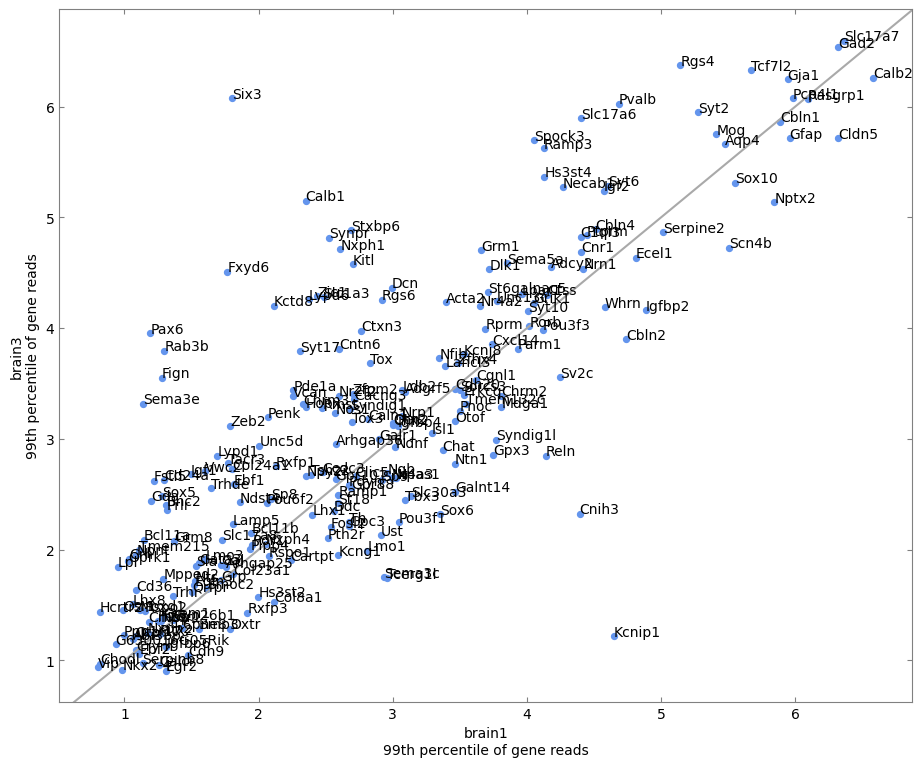

In [40]:
# Plot the 99th percentile of reads for brain1 vs brain3
# Are any gene egregiously off the diagonal?
pct = 0.99
gene_99pct_brain1 = adata_brain1[:,genes].to_df().quantile(pct)
gene_99pct_brain3 = adata_brain3[:,genes].to_df().quantile(pct)

plot_brain1_vs_brain3_percentile(gene_99pct_brain1, gene_99pct_brain3, 
                                 genes, int(pct*100), 
                                 genes_to_highlight=None)

## 99.9th percentile

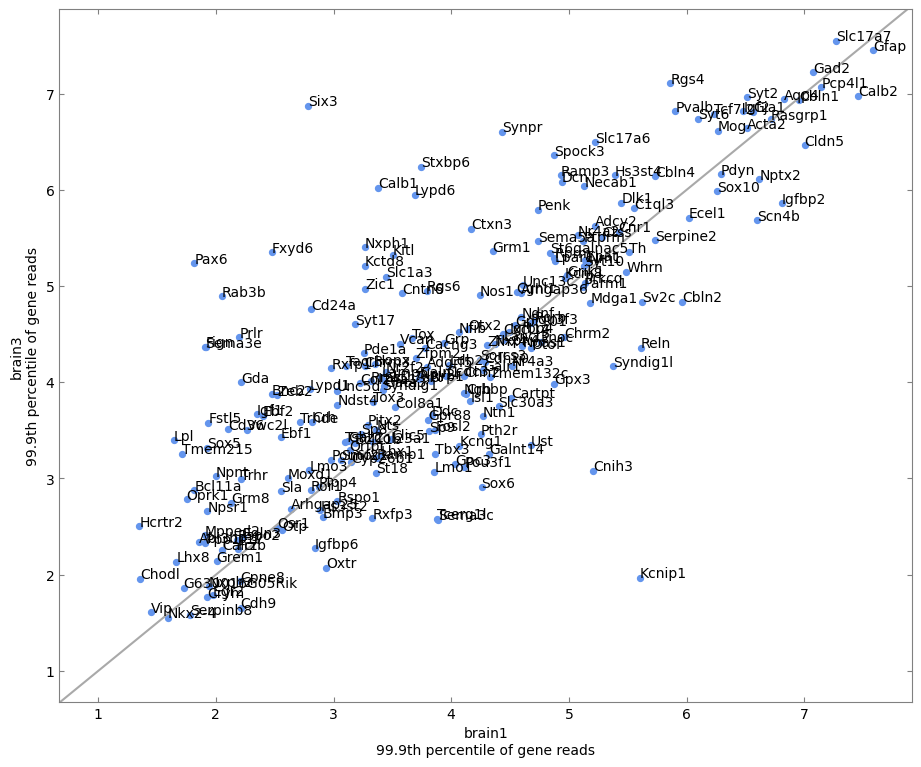

In [41]:
# Plot the 99.9th percentile of reads for brain1 vs brain3
# Are any gene egregiously off the diagonal?
pct = 0.999
gene_99pt9pct_brain1 = adata_brain1[:,genes].to_df().quantile(pct)
gene_99pt9pct_brain3 = adata_brain3[:,genes].to_df().quantile(pct)

plot_brain1_vs_brain3_percentile(gene_99pt9pct_brain1, gene_99pt9pct_brain3, 
                                 genes, pct*100, 
                                 genes_to_highlight=None)

# Mean-difference (MD) plots

aka Bland-Altman plot, aka Tukey mean-difference plot, typically used for determining variance or inconsistencies between two measurement methods in fields like analytical chemistry & clinical laboratories

x-axis: average of two methods of measuring the same underlying values

y-axis: difference between the two methods

## MD functions

### is_difference_distribution_normal()

In [42]:
import warnings
from scipy import stats

# Function to check if the difference between brain1 & brain3 values is normally
# distributed
def is_difference_distribution_normal(measurement1, measurement2,
                                      zscore_thresh=1.96, data_transform=None):
    """
    Checks if the difference between two measurement sets is normally 
    distributed.

    The applicability of the Limits of Agreement (LoA) for a Bland-Altman 
    mean-difference (MD) plot are based on the assumption that the differences
    between the two measurements are normally distribution, so it's imperative
    to check for normality before interpreting Bland-Altman plots

    Parameters
    ----------
    measurement1 : array-like
        Array of numbers from one measurement of the underlying values
    measurement2 : array-like
        Array of numbers from another, different, measurement of the underlying 
        values
    zscore_thresh : float (default:1.96)
    data_transform : {'log', None, 'none'} (default: None)
        Transformation permformed on measurement1 and measurement2 prior to
        calculations for and generation of the MD plot. Possible values:
        - 'log': natural log transform of the measurements
        - 'none', None: no transform

    Returns
    -------
    figure
        Histogram and best fit normal curve
    skew_zscore
    kurtosis_zscore
    normal_stat
    """
    # Calculate difference between measurements
    if data_transform=='log':
        measurement_differences = np.log(measurement1) - np.log(measurement2)
        # clean up to remove -inf from log(0) genes and replace with nan so no error is thrown
        measurement_differences[(measurement_differences==np.inf) | 
                                (measurement_differences==-np.inf)] = np.nan
        diff_for_norm_fit = measurement_differences[~np.isnan(measurement_differences)]
    else:
        measurement_differences = measurement1 - measurement2
        diff_for_norm_fit = measurement_differences

    # Plot difference distribution & normal fit
    fig, ax = plt.subplots(figsize=(6,4))
    
    _, bins, _ = ax.hist(measurement_differences, bins=20, density=1,
                         color='cornflowerblue')
    
    mu, sigma = stats.norm.fit(diff_for_norm_fit)
    best_fit_line = stats.norm.pdf(bins, mu, sigma)
    ax.plot(bins, best_fit_line, color='darkorange')
    
    ax.set_ylabel('counts')
    if data_transform!=None:
        ax.set_xlabel(data_transform+'(difference)')
    else:
        ax.set_xlabel('difference')

    # Explicitly test & display whether or not the difference distribution 
    # matches a normal distribution
    skew_zscore, skew_pval = stats.skewtest(measurement_differences, nan_policy='omit')
    if skew_zscore > zscore_thresh:
        print('skew test zscore =', '%0.2f'%skew_zscore, 
              'indicates difference distribution has a positive skew and is not normally distributed')
    elif skew_zscore < -zscore_thresh:
        print('skew test zscore =', '%0.2f'%skew_zscore, 
              'indicates difference distribution has a negative skew and is not normally distributed')
    else:
        print('skew test zscore =', '%0.2f'%skew_zscore, 
              'indicates difference distribution has no skew and not significantly different from a normal distribution')

    kurtosis_zscore, kurtosis_pval = stats.kurtosistest(measurement_differences, nan_policy='omit')
    if kurtosis_zscore > zscore_thresh:
        print('kurtosis test zscore =', '%0.2f'%kurtosis_zscore, 
              'indicates difference distribution is more peaked than a normal distribution')
    elif kurtosis_zscore < -zscore_thresh:
        print('kurtosis test zscore =', '%0.2f'%kurtosis_zscore, 
              'indicates difference distribution is less peaked than a normal distribution')
    else:
        print('kurtosis test zscore =', '%0.2f'%kurtosis_zscore,
              'indicates difference distribution is not significantly different from a normal distribution')

    normal_stat, normal_pval = stats.normaltest(measurement_differences, nan_policy='omit')
    if normal_stat > zscore_thresh:
        print('normal test score =', '%0.2f'%normal_stat,
              'indicates difference distribution significantly deviates from a normal distribution')
    else:
        print('normal test score =','%0.2f'%normal_stat,
              'indicates difference distribution does not significantly deviate from a normal distribution')
        
    return skew_zscore, kurtosis_zscore, normal_stat
    

### generate_mean_difference_plot()

In [88]:
# Function to generate a MD plot
def generate_mean_difference_plot(measurement1, measurement2,
                                  measurement1_label='measurement1', 
                                  measurement2_label='measurement2',
                                  loa_std=2.0, data_transform=None,
                                  title=None):
    """
    Generates a mean-difference plot from two measurements of the (assumed) same
    underlying values.

    Also sometimes called a Bland-Altman plot or a Tukey mean-difference plot.

    Parameters
    ----------
    measurement1 : array-like
        Array of numbers from one measurement of the underlying values
    measurement2 : array-like
        Array of numbers from another, different, measurement of the underlying 
        values
    measurement1_label : str (default: 'measurement1')
        The label for measurement1 data, used to annotate the plot axes
    measurement1_label : str (default: 'measurement2')
        The label for measurement2 data, used to annotate the plot axes
    loa_std : float or int, positive (default: 2.0)
        Limits of agreement (LoA), specified in standard deviations from the
        mean, and used as a threshold to determine outlying data points.
        Default is 2.0 standard deviations from the mean, which in a *normal
        distribution* encompasses 95.5% of the data (1.0std=68.3%; 3.0std=99.7%)
    data_transform : {'log', None, 'none'} (default: None)
        Transformation permformed on measurement1 and measurement2 prior to
        calculations for and generation of the MD plot. Possible values:
        - 'log': natural log transform of the measurements
        - 'diff_as_pct_of_mean': 
        - 'none', None: no transform

    Returns
    -------
    outlier_genes
        List of genes flagged as outliers
    figure
        Annotated mean-difference (MD) plot
    """
    loa_std 
    
    fig, ax = plt.subplots(figsize=(11,6))
    
    # Calculate the mean and difference of the two measurements
    # transform the measurements first, if specified
    if data_transform=='log':
        # clearn up zero entries & warn user
        if np.any(measurement1==0) | np.any(measurement2==0):
            warnings.warn('\nOne or more zero values detected in measurement1 '+
                          'or measurement2. \nThese data points will be '+
                          'excluded from the final MD plot because they '+
                          'result in a divide-by-zero error in the log '+
                          'transform. \nSet data_transform=None if you wish '+
                          'to view all data points.')
            measurement1[(measurement1==0) | (measurement1==0)] = np.nan
            measurement2[(measurement2==0) | (measurement2==0)] = np.nan
        
        measurement_diff = np.log(measurement1) - np.log(measurement2)
        measurement_mean = (np.log(measurement1) + np.log(measurement2)) / 2
        
    elif data_transform=='diff_as_pct_of_mean':
        measurement_mean = (measurement1 + measurement2) / 2
        measurement_diff = ((measurement1 - measurement2)/measurement_mean)*100
        
    elif (data_transform==None) | (data_transform=='none'):
        measurement_diff = measurement1 - measurement2
        measurement_mean = (measurement1 + measurement2) / 2
        
    # Calculate the mean & std of the difference to use for the LoA
    diff_mean = np.nanmean(measurement_diff)
    diff_std = np.nanstd(measurement_diff)

    # Generate the MD plot
    ax.scatter(measurement_mean, measurement_diff, s=18, color='cornflowerblue')
    for i, gene in enumerate(genes):
        ax.annotate(genes[i], (measurement_mean[i], measurement_diff[i]))

    # Show and label the mean & loa_std values
    annotate_ypos_offset = 0.015*np.nanmax(np.absolute(measurement_diff))
    annotate_xpos = 0.90*np.nanmax(measurement_mean)
    ax.axhline(diff_mean, color='grey', linestyle='--')
    ax.axhline(diff_mean + 1.96*diff_std, color='darkorange', linestyle='--')
    ax.axhline(diff_mean - 1.96*diff_std, color='darkorange', linestyle='--')
    ax.annotate('$\mu$ = %0.4f'%diff_mean, 
                (annotate_xpos,diff_mean+annotate_ypos_offset), 
                color='grey')
    ax.annotate('$\mu+$'+str(loa_std)+'$\sigma =$ %0.2f'%(diff_mean + loa_std*diff_std), 
                (annotate_xpos,(diff_mean + loa_std*diff_std+annotate_ypos_offset)), 
                color='darkorange')
    ax.annotate('$\mu+$'+str(loa_std)+'$\sigma =$ %0.2f'%(diff_mean - loa_std*diff_std), 
                (annotate_xpos,((diff_mean - loa_std*diff_std)+annotate_ypos_offset)), 
                color='darkorange')
    
    if (data_transform=='none') | (data_transform==None):
        ax.set_xlabel('mean( ('+measurement1_label+'), ('+measurement2_label+') )')
        ax.set_ylabel('('+measurement1_label+') - ('+measurement2_label+')')
    elif data_transform=='log':
        ax.set_xlabel('mean( '+data_transform+'('+measurement1_label+'), '+data_transform+'('+measurement2_label+') )')
        ax.set_ylabel(data_transform+'('+measurement1_label+') - '+data_transform+'('+measurement2_label+')')
    elif data_transform=='diff_as_pct_of_mean':
        ax.set_xlabel('mean( ('+measurement1_label+'), ('+measurement2_label+') )')
        ax.set_ylabel('(('+measurement1_label+')-('+measurement2_label+')) / mean \n(%)')
    
    ax.set_title(title)
    plt.show()
    
    # Generate a list of flagged genes (those outside the LoA)
    brain1_outlier_flag = (measurement_diff < (diff_mean - loa_std*diff_std))
    brain3_outlier_flag = (measurement_diff > (diff_mean + loa_std*diff_std))
    
    print('brain1 flagged genes:', sorted(measurement_diff[brain1_outlier_flag].index.tolist()))
    print('brain3 flagged genes:', sorted(measurement_diff[brain3_outlier_flag].index.tolist()))
    
    outlier_genes_list = measurement_diff[brain1_outlier_flag | brain3_outlier_flag].index
    
    return measurement_diff, brain1_outlier_flag, brain3_outlier_flag, outlier_genes_list

## Initialize df to store MD results

In [79]:
# Create a df of all the genes so that we can easily compare all the flags 
# we're about to generate
mean_diff_results_df = pd.DataFrame(index=genes)

## Standard MD plot

The standard MD plots may not actually be helpful because we are trying to compare data points spanning 3 orders of magnitude using the same scale.

So genes like Gad2, which we have visually confirmed to be fine in both datasets, end up falling almost outside of our confidence interval simply because they have high counts and so a small difference between the two datasets looks large in absolute terms, but is not that large compared to the mean.

On the other hand, it's hard to actually get a sense of how much variation there is for the genes with both small means and small differences because they're all smashed together.

One idea on how to handle this large span is to use log(95th pct gene reads, brain X) in the mean and difference calculations, which I do below. However, I haven't found any examples where this approach was used, nor do I claim that this has any sort of statistical rigor.

Another idea, taken from "Giavarina D. (2015). Biochemia Medica. 25(2): 141-51. doi:10.11613/BM.2015.015.", is to divide the difference by the mean to plot the difference as a percentage of the mean, which is "useful when there is an increase in variability of the difference as teh magnitude of the measurement increases"


skew test zscore = -2.21 indicates difference distribution has a negative skew and is not normally distributed
kurtosis test zscore = 3.64 indicates difference distribution is more peaked than a normal distribution
normal test score = 18.17 indicates difference distribution significantly deviates from a normal distribution


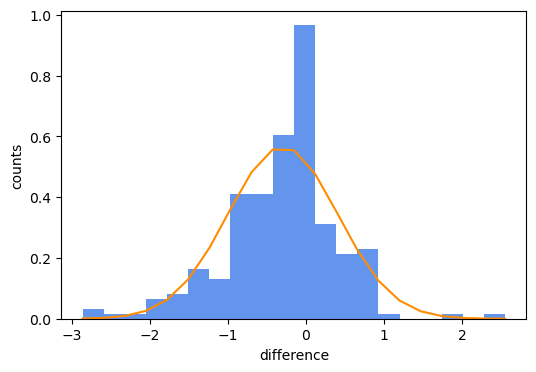

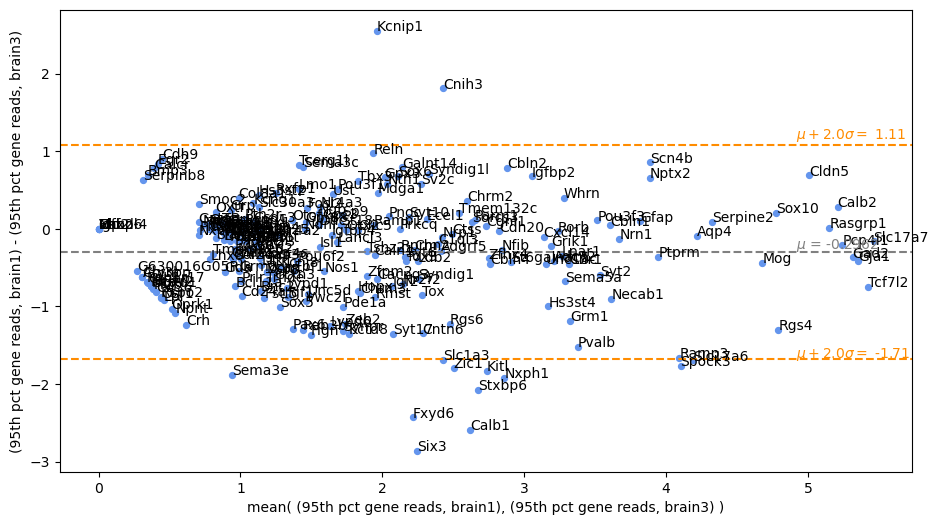

brain1 flagged genes: ['Nxph1', 'Zic1', 'Kitl', 'Calb1', 'Fxyd6', 'Spock3', 'Stxbp6', 'Sema3e', 'Six3']
brain3 flagged genes: ['Cnih3', 'Kcnip1']


In [80]:
pct = 0.95
gene_95pct_brain1 = adata_brain1[:,genes].to_df().quantile(pct)
gene_95pct_brain3 = adata_brain3[:,genes].to_df().quantile(pct)

skew_zscore, kurtosis_zscore, normal_stat = is_difference_distribution_normal(
                                                gene_95pct_brain1, 
                                                gene_95pct_brain3)
col_suffix = '_95pctReads_allCells'
(mean_diff_results_df['b1b3_diff'+col_suffix],
mean_diff_results_df['b1_flagged'+col_suffix],
mean_diff_results_df['b3_flagged'+col_suffix],
outlier_genes_95pct) = generate_mean_difference_plot(gene_95pct_brain1,
                                                    gene_95pct_brain3, 
                                                    '95th pct gene reads, brain1', 
                                                    '95th pct gene reads, brain3',
                                                    loa_std=2.0, 
                                                    data_transform=None)

## Modified MD w/ log-transformed data

The read counts span 3 orders of magnitude, so calculating the mean and difference of the log-transformed 95th percentile of reads should make things more quantitatively comparable

HOWEVER, because the 95th percentile read for many genes is still 0, and log(0)=-inf, a number of genes are simply not represented in that plot at all.

The minimum read for 99th percentile is 1.0, so the log transform of that metric does not have the same problem

Due to the gene drop-out in the 95th percentile, it's best to only use this plot with the 99th percentile (or whatever percentile's minimus is >0)

In [45]:
# Don't use 95th pct in log-transformed plots due to gene drop-out when reads=0

# pct = 0.95
# gene_95pct_brain1 = adata_brain1[:,genes].to_df().quantile(pct)
# gene_95pct_brain3 = adata_brain3[:,genes].to_df().quantile(pct)

# skew_zscore, kurtosis_zscore, normal_stat = is_difference_distribution_normal(
#                                                 gene_95pct_brain1, 
#                                                 gene_95pct_brain3,
#                                                 data_transform='log')

# # MD plot of the log-transformed 95th percentile of gene reads
# outlier_genes_95pct =  generate_mean_difference_plot(gene_95pct_brain1, gene_95pct_brain3, 
#                                                       '95th pct gene reads, brain1', 
#                                                       '95th pct gene reads, brain3',
#                                                       loa_std=2, data_transform='log')

### MD of 99th pct in all cells

skew test zscore = -2.12 indicates difference distribution has a negative skew and is not normally distributed
kurtosis test zscore = 4.07 indicates difference distribution is more peaked than a normal distribution
normal test score = 21.08 indicates difference distribution significantly deviates from a normal distribution


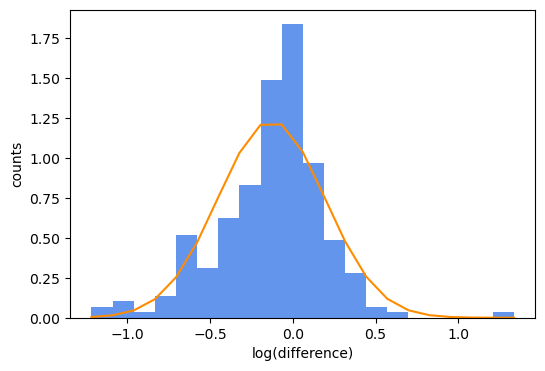

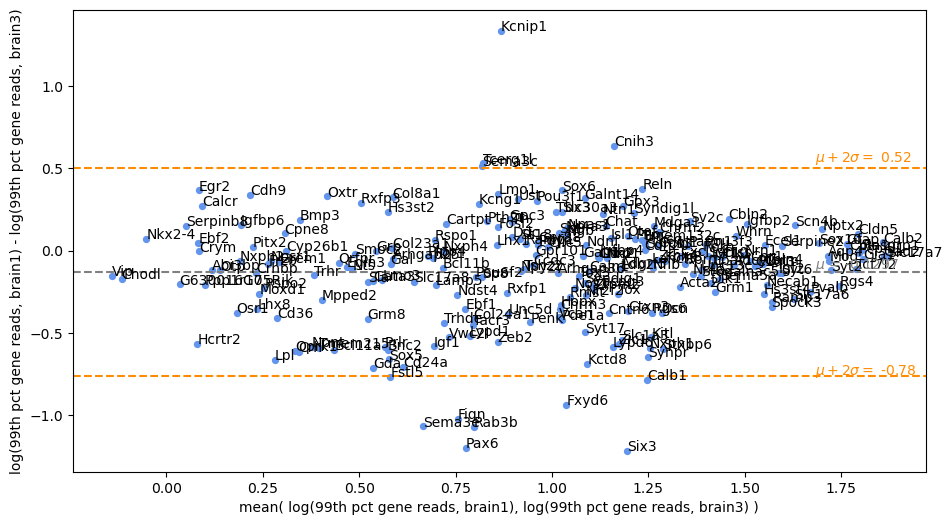

brain1 flagged genes: ['Pax6', 'Fign', 'Calb1', 'Fxyd6', 'Sema3e', 'Rab3b', 'Six3']
brain3 flagged genes: ['Cnih3', 'Kcnip1', 'Tcerg1l']


In [81]:
# MD plot of the log-transformed 99th percentile of gene reads
# for brain1 & brain3 all genes' 99th pct > 0
pct = 0.99
gene_99pct_brain1 = adata_brain1[:,genes].to_df().quantile(pct)
gene_99pct_brain3 = adata_brain3[:,genes].to_df().quantile(pct)

skew_zscore, kurtosis_zscore, normal_stat = is_difference_distribution_normal(
                                                gene_99pct_brain1, 
                                                gene_99pct_brain3,
                                                data_transform='log')

col_suffix = '_99pctLogReads_allCells'
(mean_diff_results_df['b1b3_diff'+col_suffix],
mean_diff_results_df['b1_flagged'+col_suffix],
mean_diff_results_df['b3_flagged'+col_suffix],
outlier_genes_99pct_log) = generate_mean_difference_plot(gene_99pct_brain1,
                                                        gene_99pct_brain3, 
                                                        '99th pct gene reads, brain1', 
                                                        '99th pct gene reads, brain3',
                                                        loa_std=2, data_transform='log')

### MD of 99th pct in subsets (neurons, NN, exc, inh)

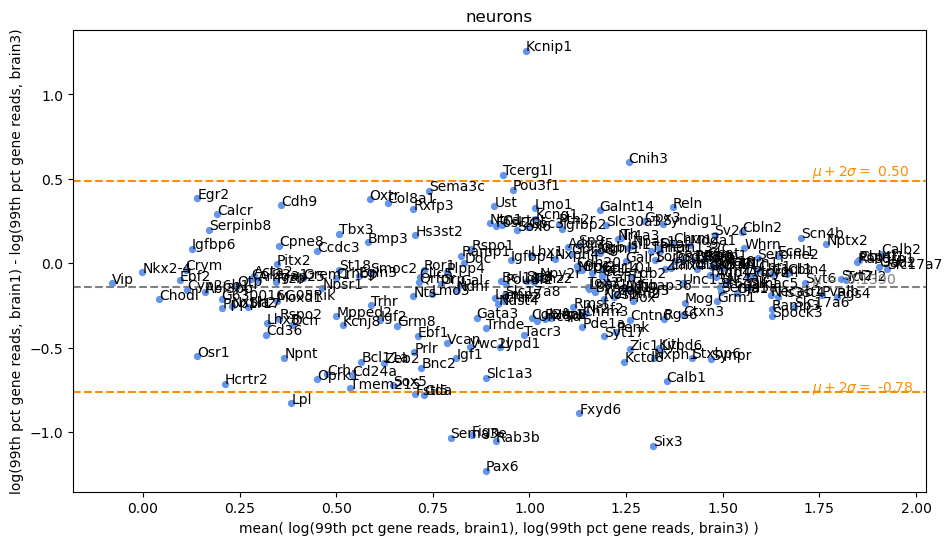

brain1 flagged genes: ['Pax6', 'Lpl', 'Gda', 'Fign', 'Fxyd6', 'Sema3e', 'Rab3b', 'Six3']
brain3 flagged genes: ['Cnih3', 'Kcnip1', 'Tcerg1l']


<ipython-input-77-873fb1225977>:52: UserWarning: 
One or more zero values detected in measurement1 or measurement2. 
These data points will be excluded from the final MD plot because they result in a divide-by-zero error in the log transform. 
Set data_transform=None if you wish to view all data points.
  warnings.warn('\nOne or more zero values detected in measurement1 '+


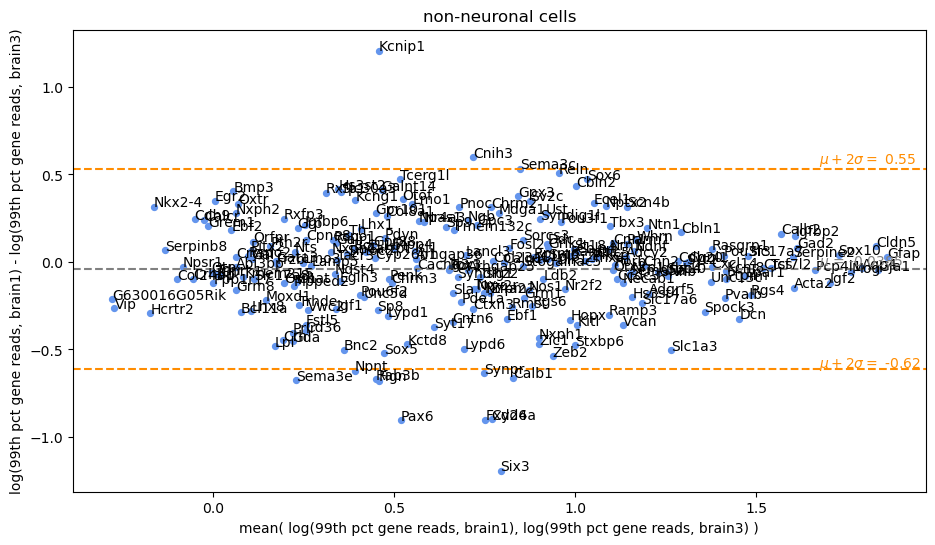

brain1 flagged genes: ['Cd24a', 'Pax6', 'Fign', 'Calb1', 'Fxyd6', 'Sema3e', 'Synpr', 'Rab3b', 'Six3']
brain3 flagged genes: ['Cnih3', 'Kcnip1']


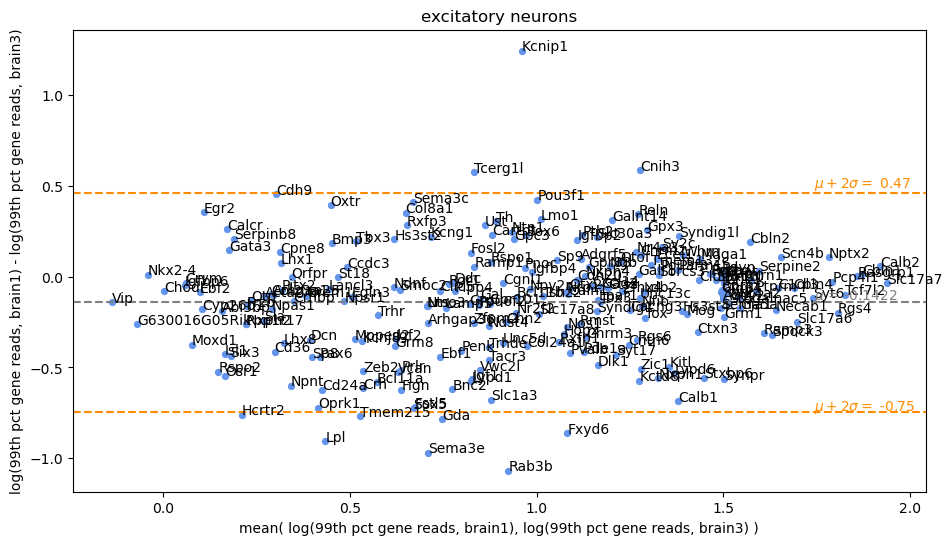

brain1 flagged genes: ['Lpl', 'Gda', 'Hcrtr2', 'Tmem215', 'Fxyd6', 'Sema3e', 'Rab3b']
brain3 flagged genes: ['Cnih3', 'Kcnip1', 'Tcerg1l']


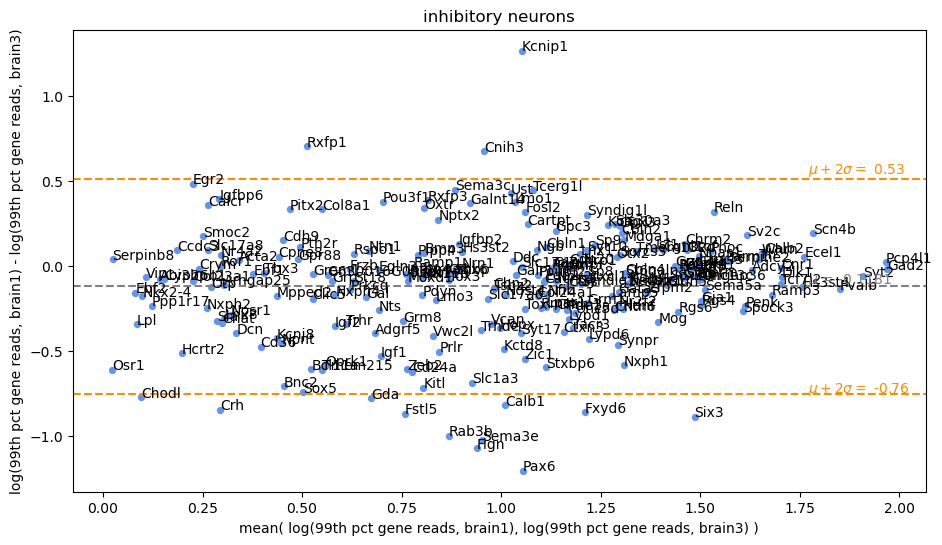

brain1 flagged genes: ['Pax6', 'Gda', 'Fign', 'Calb1', 'Fxyd6', 'Sema3e', 'Chodl', 'Rab3b', 'Crh', 'Six3', 'Fstl5']
brain3 flagged genes: ['Cnih3', 'Kcnip1', 'Rxfp1']


In [86]:
pct = 0.99

# neurons
gene_99pct_brain1_neurons = adata_brain1[neuron_filter_brain1, genes].to_df().quantile(pct) 
gene_99pct_brain3_neurons = adata_brain3[neuron_filter_brain3, genes].to_df().quantile(pct)

col_suffix = '_99pctLogReads_neurons'
(mean_diff_results_df['b1b3_diff'+col_suffix],
mean_diff_results_df['b1_flagged'+col_suffix],
mean_diff_results_df['b3_flagged'+col_suffix],
outlier_genes_99pct_neurons) = generate_mean_difference_plot(
                                    gene_99pct_brain1_neurons,
                                    gene_99pct_brain3_neurons, 
                                    '99th pct gene reads, brain1', 
                                    '99th pct gene reads, brain3',
                                    loa_std=2, data_transform='log', 
                                    title='neurons')

# non-neuronal cells
gene_99pct_brain1_nn = adata_brain1[~neuron_filter_brain1, genes].to_df().quantile(pct) 
gene_99pct_brain3_nn = adata_brain3[~neuron_filter_brain3, genes].to_df().quantile(pct) 

col_suffix = '_99pctLogReads_nn'
(mean_diff_results_df['b1b3_diff'+col_suffix],
mean_diff_results_df['b1_flagged'+col_suffix],
mean_diff_results_df['b3_flagged'+col_suffix],
outlier_genes_99pct_nn) = generate_mean_difference_plot(
                                    gene_99pct_brain1_nn,
                                    gene_99pct_brain3_nn, 
                                    '99th pct gene reads, brain1', 
                                    '99th pct gene reads, brain3',
                                    loa_std=2, data_transform='log', 
                                    title='non-neuronal cells')

# excitatory neurons
gene_99pct_brain1_exc = adata_brain1[exc_neuron_filter_brain1, genes].to_df().quantile(pct) 
gene_99pct_brain3_exc = adata_brain3[exc_neuron_filter_brain3, genes].to_df().quantile(pct) 

col_suffix = '_99pctLogReads_exc'
(mean_diff_results_df['b1b3_diff'+col_suffix],
mean_diff_results_df['b1_flagged'+col_suffix],
mean_diff_results_df['b3_flagged'+col_suffix],
outlier_genes_99pct_exc) = generate_mean_difference_plot(
                                    gene_99pct_brain1_exc,
                                    gene_99pct_brain3_exc, 
                                    '99th pct gene reads, brain1', 
                                    '99th pct gene reads, brain3',
                                    loa_std=2, data_transform='log', 
                                    title='excitatory neurons')

# inhibitory neurons
gene_99pct_brain1_inh = adata_brain1[inh_neuron_filter_brain1, genes].to_df().quantile(pct) 
gene_99pct_brain3_inh = adata_brain3[inh_neuron_filter_brain3, genes].to_df().quantile(pct) 

col_suffix = '_99pctLogReads_inh'
(mean_diff_results_df['b1b3_diff'+col_suffix],
mean_diff_results_df['b1_flagged'+col_suffix],
mean_diff_results_df['b3_flagged'+col_suffix],
outlier_genes_99pct_inh) = generate_mean_difference_plot(
                                    gene_99pct_brain1_inh,
                                    gene_99pct_brain3_inh, 
                                    '99th pct gene reads, brain1', 
                                    '99th pct gene reads, brain3',
                                    loa_std=2, data_transform='log', 
                                    title='inhibitory neurons')

### Flagged genes from log-transformed MD


In [50]:
print('Number of 99th percentile outlier genes, using log-transformed difference, in all cells:', 
      len(outlier_genes_99pct_log),'\n', sorted(outlier_genes_99pct_log))

print('\nNumber of 99th percentile outlier genes, using log-transformed difference, in neurons:', 
      len(outlier_genes_99pct_neurons),'\n', sorted(outlier_genes_99pct_neurons))

print('\nNumber of 99th percentile outlier genes, using log-transformed difference, in non-neuronal cells:', 
      len(outlier_genes_99pct_nn),'\n', sorted(outlier_genes_99pct_nn))

print('\nNumber of 99th percentile outlier genes, using log-transformed difference, in excitatory neurons:', 
      len(outlier_genes_99pct_exc),'\n', sorted(outlier_genes_99pct_exc))

print('\nNumber of 99th percentile outlier genes, using log-transformed difference, in inhibitory neurons:', 
      len(outlier_genes_99pct_inh),'\n', sorted(outlier_genes_99pct_inh))

Number of 99th percentile outlier genes, using log-transformed difference, in all cells: 10 
 ['Calb1', 'Cnih3', 'Fign', 'Fxyd6', 'Kcnip1', 'Pax6', 'Rab3b', 'Sema3e', 'Six3', 'Tcerg1l']

Number of 99th percentile outlier genes, using log-transformed difference, in neurons: 11 
 ['Cnih3', 'Fign', 'Fxyd6', 'Gda', 'Kcnip1', 'Lpl', 'Pax6', 'Rab3b', 'Sema3e', 'Six3', 'Tcerg1l']

Number of 99th percentile outlier genes, using log-transformed difference, in non-neuronal cells: 11 
 ['Calb1', 'Cd24a', 'Cnih3', 'Fign', 'Fxyd6', 'Kcnip1', 'Pax6', 'Rab3b', 'Sema3e', 'Six3', 'Synpr']

Number of 99th percentile outlier genes, using log-transformed difference, in excitatory neurons: 10 
 ['Cnih3', 'Fxyd6', 'Gda', 'Hcrtr2', 'Kcnip1', 'Lpl', 'Rab3b', 'Sema3e', 'Tcerg1l', 'Tmem215']

Number of 99th percentile outlier genes, using log-transformed difference, in inhibitory neurons: 14 
 ['Calb1', 'Chodl', 'Cnih3', 'Crh', 'Fign', 'Fstl5', 'Fxyd6', 'Gda', 'Kcnip1', 'Pax6', 'Rab3b', 'Rxfp1', 'Sema3e', 'Six3

In [51]:
outlier_genes_all = sorted(list(dict.fromkeys([*outlier_genes_99pct_log, 
                                               *outlier_genes_99pct_neurons, 
                                               *outlier_genes_99pct_nn, 
                                               *outlier_genes_99pct_exc, 
                                               *outlier_genes_99pct_inh])))
print(outlier_genes_all)

['Calb1', 'Cd24a', 'Chodl', 'Cnih3', 'Crh', 'Fign', 'Fstl5', 'Fxyd6', 'Gda', 'Hcrtr2', 'Kcnip1', 'Lpl', 'Pax6', 'Rab3b', 'Rxfp1', 'Sema3e', 'Six3', 'Synpr', 'Tcerg1l', 'Tmem215']


### Spatial expression plots of flagged genes

#### display_brain1_vs_brain3_expression()

In [64]:
def display_brain1_vs_brain3_expression(ad, gene, **kwargs):
    """ Display the spatial expression of a requested list of genes for two
    example sections of brain1 and brain3 """
    
    # Define the two example sections that provide the best comparison
    example_sections_brain1 = ['1198980108', '1198980114']  # '1198980101',
    example_sections_brain3 = ['1199651045', '1199651042']  # '1199651048', 
    
    # Distinguish between the two brains by using the codebook names
    codebook_brain1 = 'VZG147'
    codebook_brain3 = 'wholebrain031822a'

    # Get adata views of each section
    sec0_brain1 = ad[(ad.obs['codebook']==codebook_brain1) & (ad.obs['section']==example_sections_brain1[0])]
    sec1_brain1 = ad[(ad.obs['codebook']==codebook_brain1) & (ad.obs['section']==example_sections_brain1[1])]
    sec0_brain3 = ad[(ad.obs['codebook']==codebook_brain3) & (ad.obs['section']==example_sections_brain3[0])]
    sec1_brain3 = ad[(ad.obs['codebook']==codebook_brain3) & (ad.obs['section']==example_sections_brain3[1])]

    fig, ax = plt.subplots(1, figsize=(9,6))

    # The transcript counts are stored in a sparse matrix, which cannot be
    # directly plotted w/out first: making dense, converting to an np.array,
    # and then flattening
    gene_exp_sec0_brain1 = np.array(sparse.csr_matrix.todense(sec0_brain1[:,gene].layers['raw'])).flatten()
    gene_exp_sec1_brain1 = np.array(sparse.csr_matrix.todense(sec1_brain1[:,gene].layers['raw'])).flatten()
    gene_exp_sec0_brain3 = np.array(sparse.csr_matrix.todense(sec0_brain3[:,gene].layers['raw'])).flatten()
    gene_exp_sec1_brain3 = np.array(sparse.csr_matrix.todense(sec1_brain3[:,gene].layers['raw'])).flatten()
    
    # Set some values for use in scatter()
    xaxis_shift = 10000  # tighen up spatial_cirro spacing of two sections
    yaxis_shift_brain3_sec1 = 400  # better alignment of the brain3 sections
    colormap = 'Blues'
    marker_size = 0.5

    sc = ax.scatter(sec0_brain1[:,gene].obsm["spatial_cirro"][:,0],
                    sec0_brain1[:,gene].obsm["spatial_cirro"][:,1], 
                    c=gene_exp_sec0_brain1, 
                    cmap=colormap, s=marker_size)
    ax.annotate('brain1', (42000,-4200), ha='right', color='grey')
    ax.annotate('Section 1198980108', (45000,-2700), ha='center', color='grey')
    ax.scatter(sec1_brain1[:,gene].obsm["spatial_cirro"][:,0]-xaxis_shift,
               sec1_brain1[:,gene].obsm["spatial_cirro"][:,1], 
               c=gene_exp_sec1_brain1, 
               cmap=colormap, s=marker_size)
    ax.annotate('Section 1198980114', (51000,-2700), ha='center', color='grey')
    ax.scatter(sec0_brain3[:,gene].obsm["spatial_cirro"][:,0],
               sec0_brain3[:,gene].obsm["spatial_cirro"][:,1], 
               c=gene_exp_sec0_brain3, 
               cmap=colormap, s=marker_size)
    ax.annotate('brain3', (42000,-8900), ha='right', color='grey')
    ax.scatter(sec1_brain3[:,gene].obsm["spatial_cirro"][:,0]-xaxis_shift,
               sec1_brain3[:,gene].obsm["spatial_cirro"][:,1]+yaxis_shift_brain3_sec1, 
               c=gene_exp_sec1_brain3, 
               cmap=colormap, s=marker_size)
    cbar = plt.colorbar(sc,fraction=0.03, pad=0.04)
    cbar.set_label('# of transcripts in cell')
    
    # formatting
    ax.set_aspect('equal')
    ax.axis('off')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(gene)

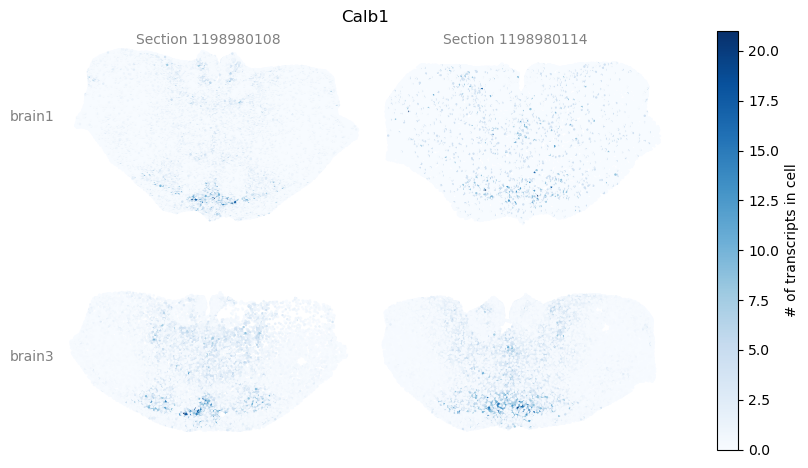

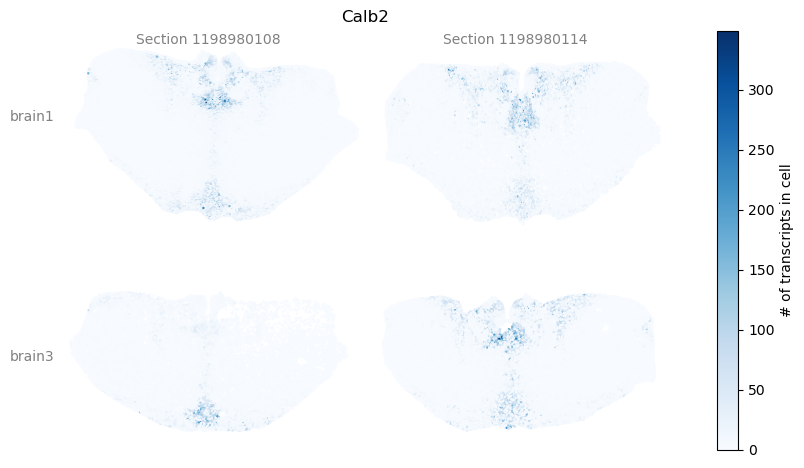

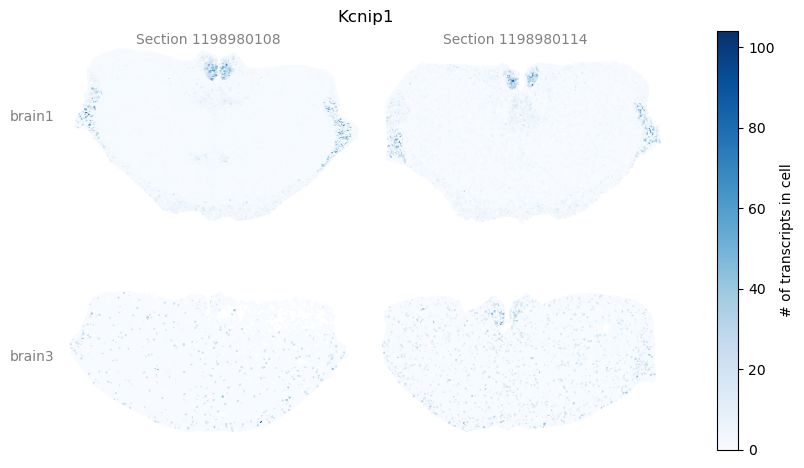

In [65]:
display_brain1_vs_brain3_expression(adata, 'Calb1')
display_brain1_vs_brain3_expression(adata, 'Calb2')
display_brain1_vs_brain3_expression(adata, 'Kcnip1')

## Modified MD w/ difference as % of mean on y-axis

Another idea for how to handle the large range of values in gene reads is to divide the difference by the mean to plot the difference as a percentage of the mean, which is "useful when there is an increase in variability of the difference as teh magnitude of the measurement increases" (reference: Figure 7 in "Giavarina D. (2015). Biochemia Medica. 25(2): 141-51. doi:10.11613/BM.2015.015.")


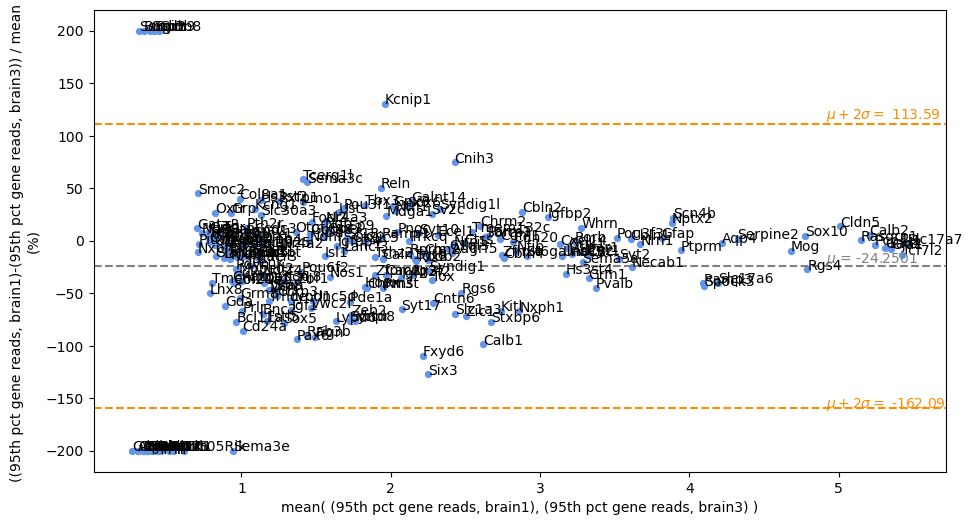

brain1 flagged genes: ['Abi3bp', 'Cd36', 'Crh', 'Crhbp', 'Crym', 'Frzb', 'G630016G05Rik', 'Hcrtr2', 'Lpl', 'Moxd1', 'Npnt', 'Oprk1', 'Osr1', 'Otp', 'Ppp1r17', 'Rspo2', 'Sema3e']
brain3 flagged genes: ['Bmp3', 'Calcr', 'Cdh9', 'Egr2', 'Kcnip1', 'Serpinb8']


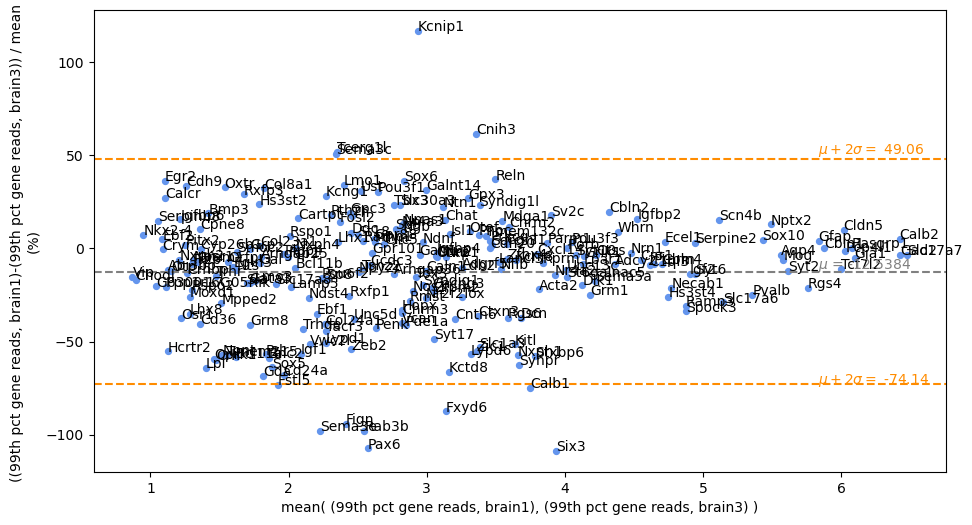

brain1 flagged genes: ['Calb1', 'Fign', 'Fxyd6', 'Pax6', 'Rab3b', 'Sema3e', 'Six3']
brain3 flagged genes: ['Cnih3', 'Kcnip1', 'Sema3c', 'Tcerg1l']


In [89]:
# 95th percentile, all cells
pct = 0.95
gene_95pct_brain1 = adata_brain1[:,genes].to_df().quantile(pct)
gene_95pct_brain3_neurons = adata_brain3[:,genes].to_df().quantile(pct)

col_suffix = '_95pctReads_diffAsPctOfMean_allCells'
(mean_diff_results_df['b1b3_diff'+col_suffix],
mean_diff_results_df['b1_flagged'+col_suffix],
mean_diff_results_df['b3_flagged'+col_suffix],
outlier_genes_95pct_diffAsPctOfMean) = generate_mean_difference_plot(
                                        gene_95pct_brain1,
                                        gene_95pct_brain3, 
                                        '95th pct gene reads, brain1', 
                                        '95th pct gene reads, brain3',
                                        loa_std=2, 
                                        data_transform='diff_as_pct_of_mean')

# 99th percentile, all cells
pct = 0.99
gene_99pct_brain1 = adata_brain1[:,genes].to_df().quantile(pct)
gene_99pct_brain3 = adata_brain3[:,genes].to_df().quantile(pct)

col_suffix = '_95pctReads_diffAsPctOfMean_allCells'
(mean_diff_results_df['b1b3_diff'+col_suffix],
mean_diff_results_df['b1_flagged'+col_suffix],
mean_diff_results_df['b3_flagged'+col_suffix],
outlier_genes_99pct_diffAsPctOfMean) = generate_mean_difference_plot(
                                        gene_99pct_brain1,
                                        gene_99pct_brain3, 
                                        '99th pct gene reads, brain1', 
                                        '99th pct gene reads, brain3',
                                        loa_std=2, 
                                        data_transform='diff_as_pct_of_mean')

### Flagged genes from diff as % of mean

In [58]:
print('Number of 95th percentile outlier genes, using difference as a percent of the mean, in all cells:', 
      len(outlier_genes_95pct_diffAsPctOfMean),'\n', sorted(outlier_genes_95pct_diffAsPctOfMean))

print('\nNumber of 99th percentile outlier genes, using difference as a percent of the mean, in all cells:', 
      len(outlier_genes_99pct_diffAsPctOfMean),'\n', sorted(outlier_genes_99pct_diffAsPctOfMean))

Number of 95th percentile outlier genes, using difference as a percent of the mean, in all cells: 23 
 ['Abi3bp', 'Bmp3', 'Calcr', 'Cd36', 'Cdh9', 'Crh', 'Crhbp', 'Crym', 'Egr2', 'Frzb', 'G630016G05Rik', 'Hcrtr2', 'Kcnip1', 'Lpl', 'Moxd1', 'Npnt', 'Oprk1', 'Osr1', 'Otp', 'Ppp1r17', 'Rspo2', 'Sema3e', 'Serpinb8']

Number of 99th percentile outlier genes, using difference as a percent of the mean, in all cells: 11 
 ['Calb1', 'Cnih3', 'Fign', 'Fxyd6', 'Kcnip1', 'Pax6', 'Rab3b', 'Sema3c', 'Sema3e', 'Six3', 'Tcerg1l']


### Plot outlier gene expression

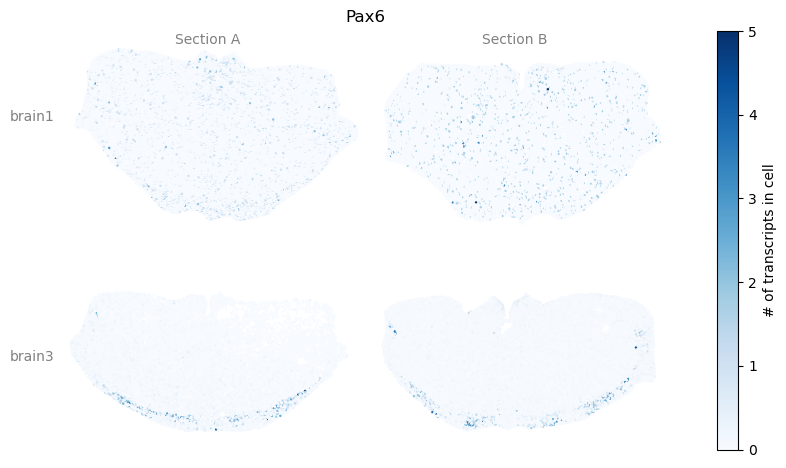

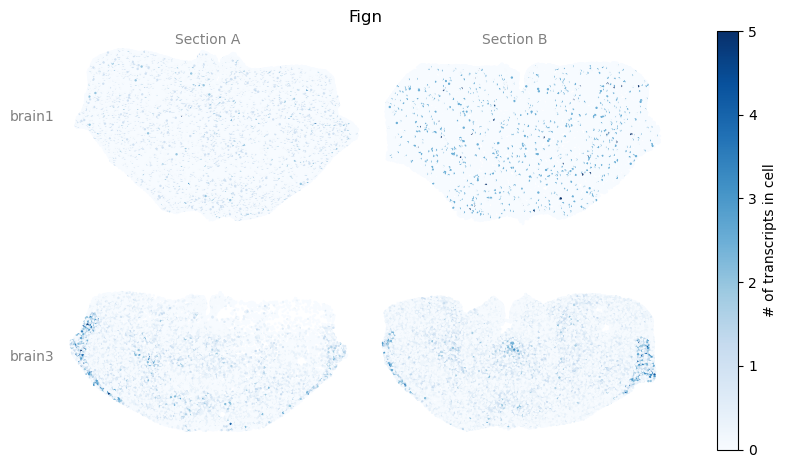

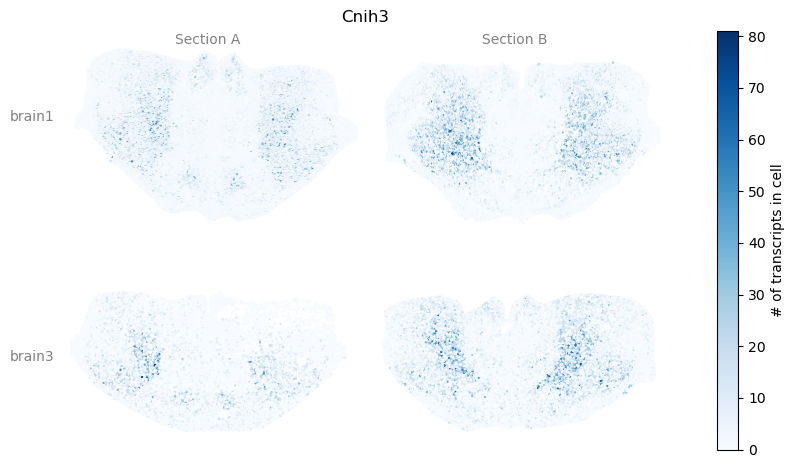

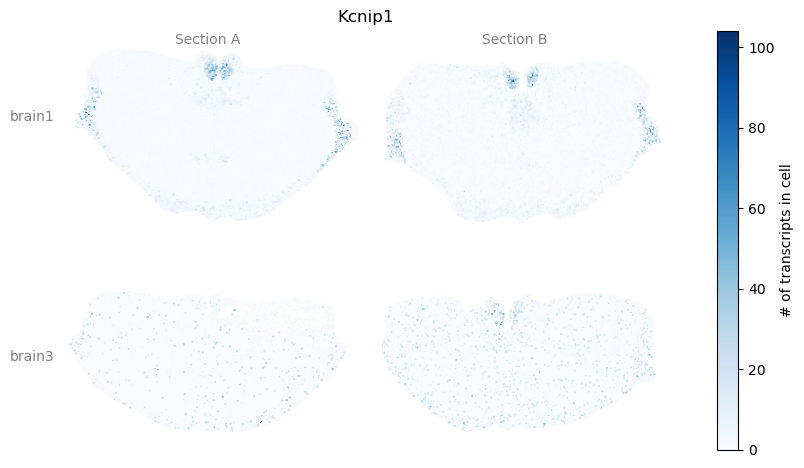

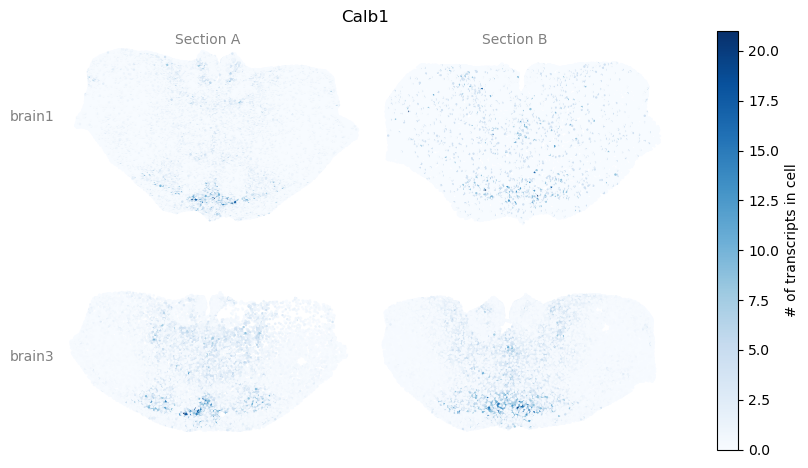

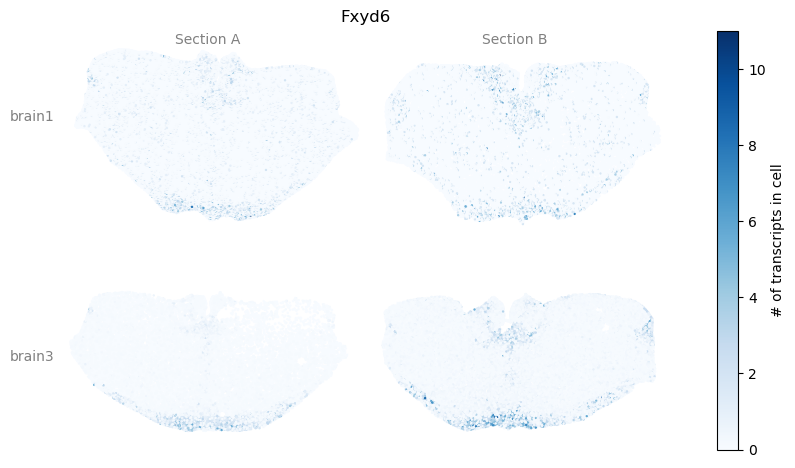

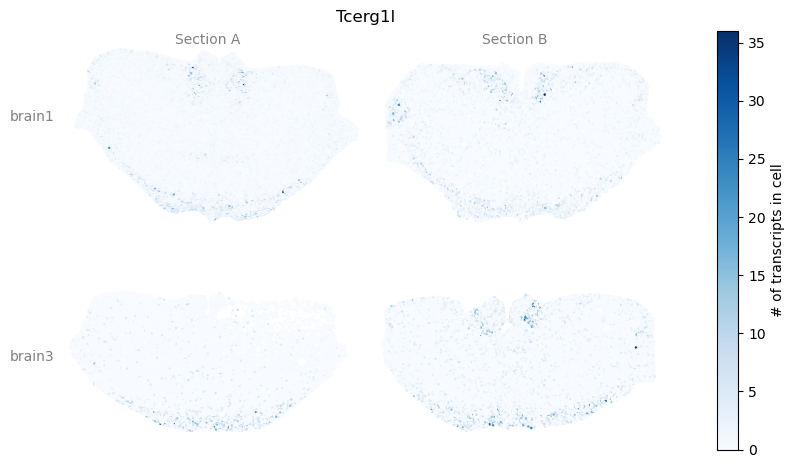

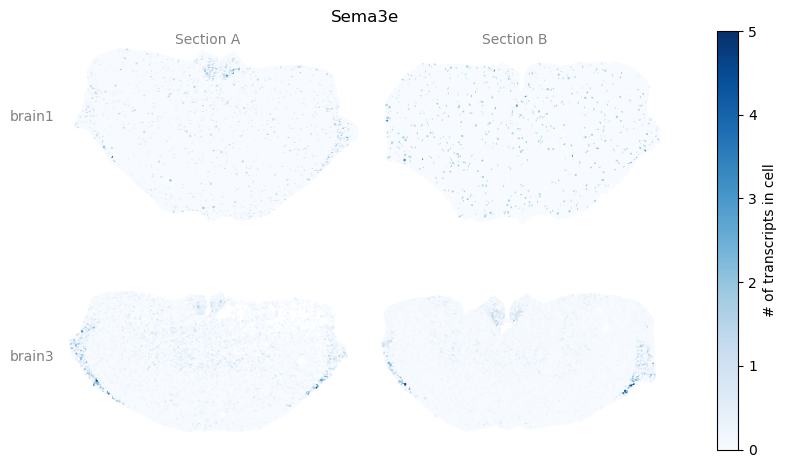

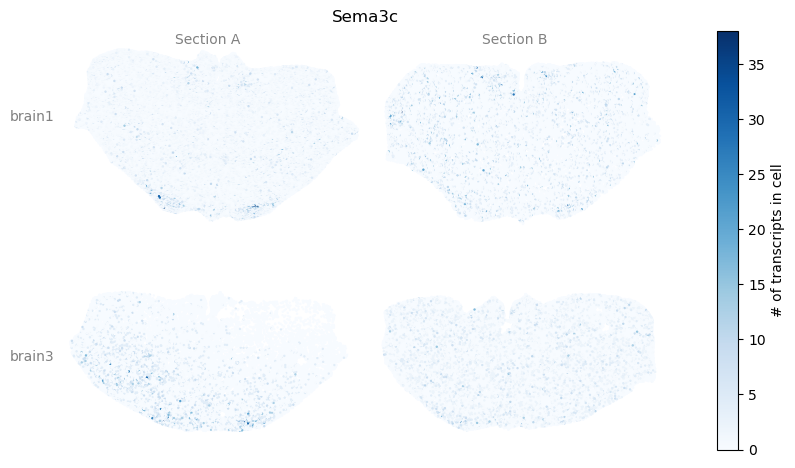

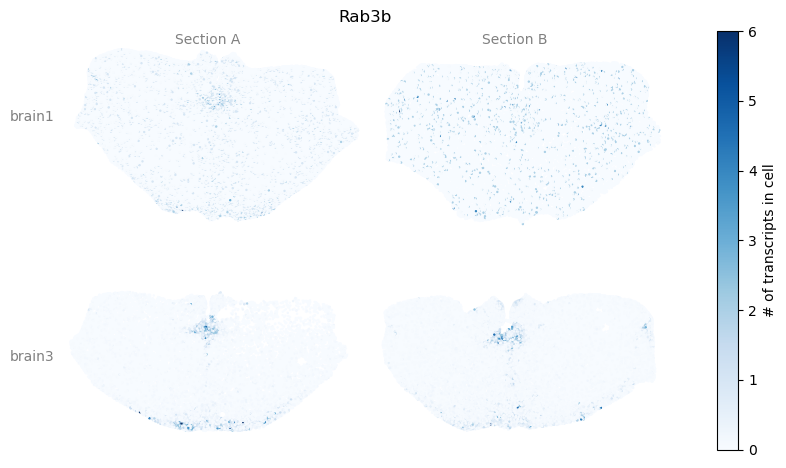

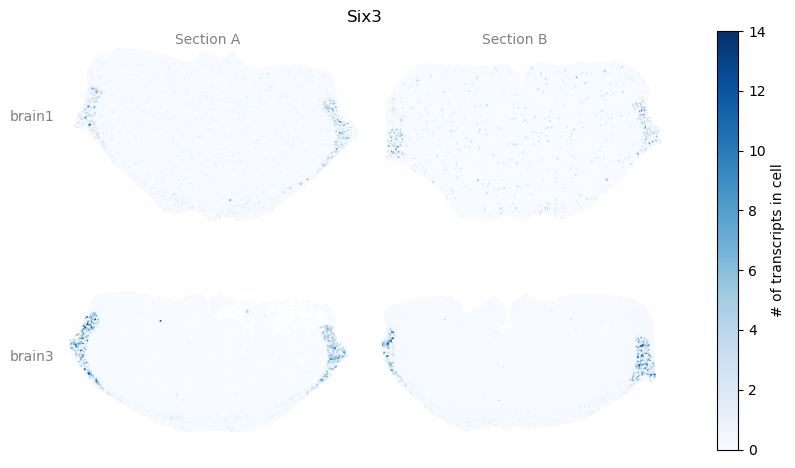

In [59]:
for gene in outlier_genes_99pct_diffAsPctOfMean:
    display_brain1_vs_brain3_expression(adata, gene)

## Save MD plot results to .uns

In [91]:
adata.uns['mean_diff_plot_results_flags'] = mean_diff_results_df
adata.write_h5ad('/root/capsule/results/Brain_1_3_TH_ZI_geneQC.h5ad')

In [92]:
mean_diff_results_df

b1b3_diff_95pctReads_allCells  b1_flagged_95pctReads_allCells  \
Trhde                       -0.675785                           False   
Grp                          0.248069                           False   
Calcr                        0.779578                           False   
Gad2                        -0.368328                           False   
Pth2r                        0.126687                           False   
...                               ...                             ...   
Rxfp1                        0.467413                           False   
Rmst                        -0.881739                           False   
Gal                          0.057899                           False   
Adgrf5                      -0.284250                           False   
Nr2f2                       -0.705748                           False   

        b3_flagged_95pctReads_allCells  b1b3_diff_99pctLogReads_allCells  \
Trhde                            False                         -0.440102   
Grp                              False                         -0.000856   
Calcr                            False                          0.273323   
Gad2                             False                         -0.033509   
Pth2r                            False                          0.178649   
...                                ...                               ...   
Rxfp1                            False                         -0.257056   
Rmst                             False                         -0.281724   
Gal                              False                         -0.080842   
Adgrf5                           False                         -0.102807   
Nr2f2                            False                         -0.267346   

        b1_flagged_99pctLogReads_allCells  b3_flagged_99pctLogReads_allCells  \
Trhde                               False                              False   
Grp                                 False                              False   
Calcr                               False                              False   
Gad2                                False                              False   
Pth2r                               False                              False   
...                                   ...                                ...   
Rxfp1                               False                              False   
Rmst                                False                              False   
Gal                                 False                              False   
Adgrf5                              False                              False   
Nr2f2                               False                              False   

        b1b3_diff_99pctLogReads_neurons  b1_flagged_99pctLogReads_neurons  \
Trhde                         -0.385731                             False   
Grp                           -0.121797                             False   
Calcr                          0.291019                             False   
Gad2                          -0.021409                             False   
Pth2r                          0.234005                             False   
...                                 ...                               ...   
Rxfp1                         -0.327628                             False   
Rmst                          -0.259001                             False   
Gal                           -0.126114                             False   
Adgrf5                         0.093523                             False   
Nr2f2                         -0.292549                             False   

        b3_flagged_99pctLogReads_neurons  b1b3_diff_99pctLogReads_nn  ...  \
Trhde                              False                   -0.245763  ...   
Grp                                False                    0.195647  ...   
Calcr                              False                    0.239820  ...   
Gad2                    

# TODO: Extending MD plot analysis to >2 replicates

Eventually, we'll want to do this for more than just these two brains, Brain 1 & Brain 3. For example, the Imaging Dept. has a series of 12(?), sequential, ~10um sections of mouse brain that they've been using as "identical" replicates to test the consistency of the Xenium. It would be great to be able to do this type of MD comparison on all 12(?) sections to flag potential outliers! However, the combinatorics of individual, pairwise MD plots quickly blows up!!

Luckily, the limma R/Bioconducter software package extends the MD / Bland-Altman plot method to compare each replicate (aka sample/method/observers/reader) to the average of all other replicates by:

"A virtual array is constructed by averaging the log-expression value for all the samples other than the sample of interest, and then a mean-difference plot is made between the single array and the virtual array." (Ritchie, et al. (2015). Nucleic Acids Research. doi:10.1093/nar/gkv007)

This may not be the most efficient way to flag instances where entire sections failed, but it should suffice.
